In [1]:
#from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import train_test_split
#from sklearn import tree

import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import os
from shutil import copy
import seaborn as sns

from matplotlib import pyplot as plt

import datetime
from dateutil.relativedelta import relativedelta
#from sklearn.linear_model import Ridge, RidgeCV
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
import pickle
# import imageio
from itertools import compress

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
#‘xx-small’, ‘x-small’, ‘small’, ‘medium’, ‘large’, ‘x-large’, ‘xx-large’
pylab.rcParams.update(params)
#from sklearn.ensemble import IsolationForest
#from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
# from statsmodels.tsa.api import VAR

#from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
#from sklearn import tree

import re

#from sklearn.preprocessing import StandardScaler
#from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score
#from scipy.optimize import curve_fit
# from tslearn.clustering import KShape, silhouette_score

import gc
import matplotlib.dates as mdates
#from sklearn.ensemble import IsolationForest
import math
import warnings
#from scipy import stats


C:\Users\podol\anaconda3\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.18.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [19]:
def weighted_avg(x, weight, factor):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tmp = x[[weight, factor]].dropna()
        weighted_sum = (tmp[weight] * tmp[factor]).sum()
        count_sum = tmp[weight].sum()
        return weighted_sum / count_sum

In [20]:
#read data
locus_weights=pd.read_csv('evt_movement_ratio_with_dates.csv')
locus_weights.starttime = pd.to_datetime(locus_weights.starttime,format='%Y-%m-%d')
locus_weights.endtime = pd.to_datetime(locus_weights.endtime,format='%Y-%m-%d')

temperature = pd.read_csv('temperature_for_CAM.csv')
temperature.event_date = pd.to_datetime(temperature.event_date,format='%Y-%m-%d')
temperature.locus_group_id=temperature.locus_group_id.astype('int16')
#not sure in row below as it 'converts' 12.3 -> 12.296875
temperature.value=temperature.value.astype('float16')
temperature['event_year']=temperature['event_date'].dt.year

llg_match= pd.read_csv('locus_locus_group_matching.csv')
llg_match.locus_id=llg_match.locus_id.astype('int32')
llg_match.locus_group_id=llg_match.locus_group_id.astype('int16')

df_dates=pd.read_csv('FW_cycle_dates.csv')
for d in ['first_movement_date', 'first_feeding_date', 'shipout_date']:
    df_dates[d] = pd.to_datetime(df_dates[d],format='%Y-%m-%d')
    
sfm = pd.read_csv('seawater_freshwater_matching.csv')
sfm_ = sfm[sfm.origin_site_type=='Freshwater'][['target_seawater_locus_id','transport_date','ponding_date','pretransfer_fw_locus_population_id','fish_count_shipped_out','avg_weight_g_stocked']]
sfm_.pretransfer_fw_locus_population_id=sfm_.pretransfer_fw_locus_population_id.astype('int64')

df_target=pd.read_csv('tmp_target.csv')
df_target['transfer_date'] = pd.to_datetime(df_target['transfer_date'],format='%Y-%m-%d')
df_target['transport_year']=df_target['transfer_date'].dt.year

lw_alldates_final = pd.read_csv('lw_alldates_final_locus.csv')
# FIX:
lw_alldates_final.event_date = pd.to_datetime(lw_alldates_final.event_date)

In [21]:
lw_dates=locus_weights.groupby('final_locus_population_id').agg({'starttime':'min','endtime':'max'})
lw_dates.starttime = pd.to_datetime(lw_dates.starttime,format='%Y-%m-%d')
lw_dates.endtime = pd.to_datetime(lw_dates.endtime,format='%Y-%m-%d')
#to be checked
lw_dates['FW_cycle_length'] = (lw_dates.endtime - lw_dates.starttime).dt.days+1
lw_dates['starttime_year']=lw_dates['starttime'].dt.year
#we limit FW cycles to those started in 2017 because there are issues with temperature readings for 2015-2016
lw_dates_2017=lw_dates[lw_dates.starttime_year>=2017]

In [22]:
lw_alldates_final_=lw_alldates_final.merge(llg_match,left_on='historic_locus_id', right_on='locus_id', how='left')
#alternatively rename column before merging. Thus not having to drop column thereafter
lw_alldates_final_.drop(columns='locus_id',inplace=True)

In [41]:
recambio_data = pd.read_csv('indicators_all_file_joined.csv', delimiter=';')

In [42]:
recambio_data

,event_ts,locus_group_id,sensor_type_value,sensor_name,type_name
0,31.12.2021,490,648,M3 Ingresados,M3 Jobs
1,31.12.2021,490,"0,53",NH4,Nitrуgeno
2,31.12.2021,490,"0,92",NO2,Nitrуgeno
3,31.12.2021,490,"7,2",pH,PH
4,31.12.2021,490,1830,Volumen M3,M3 Jobs
...,...,...,...,...,...
71888,21.01.2022,560,"4,8",Carbon dioxide,Carbon dioxide
71889,26.01.2022,560,"12,1",Carbon dioxide,Carbon dioxide
71890,07.02.2022,560,"5,4",Carbon dioxide,Carbon dioxide
71891,17.02.2022,560,"7,2",Carbon dioxide,Carbon dioxide


In [43]:
recambio_data['sensor_type_value'] = recambio_data['sensor_type_value'].str.replace(',', '.')

recambio_data['sensor_type_value'] = recambio_data['sensor_type_value'].astype(float)

In [44]:
unique_values = recambio_data['sensor_name'].drop_duplicates()

In [45]:
unique_values

0           M3 Ingresados
1                     NH4
2                     NO2
3                      pH
4              Volumen M3
5        Temperatura (°C)
6               Sal (ppt)
13            Alcalinidad
15                 Dureza
19                    NO3
21                    PO4
24          Transmitancia
98                  N-NH3
304          Recambio (%)
8022         Solidos susp
23529            Turbidez
68096      Carbon dioxide
Name: sensor_name, dtype: object

In [46]:


# Check if 'sensor_name' contains 'recambio'
has_recambio = recambio_data['sensor_name'] == 'Recambio (%)'



In [47]:
# Filter the DataFrame based on the condition
recambio_filtered = recambio_data[has_recambio]

# Create a new DataFrame with 'sensor_name' modified
recambio_new = recambio_filtered.copy()
recambio_new['sensor_name'] = 'recambio_new'

# Append the modified DataFrame to the original DataFrame
recambio_data = pd.concat([recambio_data, recambio_new], ignore_index=True)


In [48]:

ingresados = recambio_data.loc[recambio_data['sensor_name'] == 'M3 Ingresados']
volumen = recambio_data.loc[recambio_data['sensor_name'] == 'Volumen M3']


In [49]:
ingresados

,event_ts,locus_group_id,sensor_type_value,sensor_name,type_name
0,31.12.2021,490,648.0,M3 Ingresados,M3 Jobs
16,03.01.2022,490,712.0,M3 Ingresados,M3 Jobs
26,04.01.2022,490,678.7,M3 Ingresados,M3 Jobs
33,05.01.2022,490,753.4,M3 Ingresados,M3 Jobs
39,06.01.2022,490,792.0,M3 Ingresados,M3 Jobs
...,...,...,...,...,...
67917,04.03.2022,560,1196.0,M3 Ingresados,M3 Jobs
67918,05.03.2022,560,804.0,M3 Ingresados,M3 Jobs
67919,06.03.2022,560,822.0,M3 Ingresados,M3 Jobs
67920,07.03.2022,560,915.0,M3 Ingresados,M3 Jobs


In [50]:
# Assuming you have already loaded the data into the 'ingresados' and 'volumen' dataframes

# Perform an inner join on 'locus_group_id' and 'event_ts'
merged_df = pd.merge(ingresados, volumen, on=['locus_group_id', 'event_ts'], how='inner')

# Filter out rows where 'sensor_type_value' is not NaN
merged_df = merged_df.dropna(subset=['sensor_name_y'])

# Print the resulting dataframe
merged_df

,event_ts,locus_group_id,sensor_type_value_x,sensor_name_x,type_name_x,sensor_type_value_y,sensor_name_y,type_name_y
0,31.12.2021,490,648.0,M3 Ingresados,M3 Jobs,1830.0,Volumen M3,M3 Jobs
1,03.01.2022,490,712.0,M3 Ingresados,M3 Jobs,39.0,Volumen M3,M3 Jobs
2,04.01.2022,490,678.7,M3 Ingresados,M3 Jobs,1810.0,Volumen M3,M3 Jobs
3,05.01.2022,490,753.4,M3 Ingresados,M3 Jobs,1800.0,Volumen M3,M3 Jobs
4,06.01.2022,490,792.0,M3 Ingresados,M3 Jobs,1810.0,Volumen M3,M3 Jobs
...,...,...,...,...,...,...,...,...
7316,04.03.2022,560,1196.0,M3 Ingresados,M3 Jobs,3400.0,Volumen M3,M3 Jobs
7317,05.03.2022,560,804.0,M3 Ingresados,M3 Jobs,3400.0,Volumen M3,M3 Jobs
7318,06.03.2022,560,822.0,M3 Ingresados,M3 Jobs,3400.0,Volumen M3,M3 Jobs
7319,07.03.2022,560,915.0,M3 Ingresados,M3 Jobs,3400.0,Volumen M3,M3 Jobs


In [51]:
merged_df['Reacambio_new'] = 100*merged_df['sensor_type_value_x'] / merged_df['sensor_type_value_y']

In [52]:
merged_df


,event_ts,locus_group_id,sensor_type_value_x,sensor_name_x,type_name_x,sensor_type_value_y,sensor_name_y,type_name_y,Reacambio_new
0,31.12.2021,490,648.0,M3 Ingresados,M3 Jobs,1830.0,Volumen M3,M3 Jobs,35.409836
1,03.01.2022,490,712.0,M3 Ingresados,M3 Jobs,39.0,Volumen M3,M3 Jobs,1825.641026
2,04.01.2022,490,678.7,M3 Ingresados,M3 Jobs,1810.0,Volumen M3,M3 Jobs,37.497238
3,05.01.2022,490,753.4,M3 Ingresados,M3 Jobs,1800.0,Volumen M3,M3 Jobs,41.855556
4,06.01.2022,490,792.0,M3 Ingresados,M3 Jobs,1810.0,Volumen M3,M3 Jobs,43.756906
...,...,...,...,...,...,...,...,...,...
7316,04.03.2022,560,1196.0,M3 Ingresados,M3 Jobs,3400.0,Volumen M3,M3 Jobs,35.176471
7317,05.03.2022,560,804.0,M3 Ingresados,M3 Jobs,3400.0,Volumen M3,M3 Jobs,23.647059
7318,06.03.2022,560,822.0,M3 Ingresados,M3 Jobs,3400.0,Volumen M3,M3 Jobs,24.176471
7319,07.03.2022,560,915.0,M3 Ingresados,M3 Jobs,3400.0,Volumen M3,M3 Jobs,26.911765


In [53]:
merged_df['sensor_name_x'] = merged_df['sensor_name_x'].replace('M3 Ingresados', 'recambio_new')

In [54]:
merged_df = merged_df.drop('sensor_type_value_x', axis=1)
merged_df = merged_df.drop('type_name_x', axis=1)
merged_df = merged_df.drop('sensor_type_value_y', axis=1)
merged_df = merged_df.drop('sensor_name_y', axis=1)

In [55]:
merged_df

,event_ts,locus_group_id,sensor_name_x,type_name_y,Reacambio_new
0,31.12.2021,490,recambio_new,M3 Jobs,35.409836
1,03.01.2022,490,recambio_new,M3 Jobs,1825.641026
2,04.01.2022,490,recambio_new,M3 Jobs,37.497238
3,05.01.2022,490,recambio_new,M3 Jobs,41.855556
4,06.01.2022,490,recambio_new,M3 Jobs,43.756906
...,...,...,...,...,...
7316,04.03.2022,560,recambio_new,M3 Jobs,35.176471
7317,05.03.2022,560,recambio_new,M3 Jobs,23.647059
7318,06.03.2022,560,recambio_new,M3 Jobs,24.176471
7319,07.03.2022,560,recambio_new,M3 Jobs,26.911765


In [56]:
recambio_data

,event_ts,locus_group_id,sensor_type_value,sensor_name,type_name
0,31.12.2021,490,648.00,M3 Ingresados,M3 Jobs
1,31.12.2021,490,0.53,NH4,Nitrуgeno
2,31.12.2021,490,0.92,NO2,Nitrуgeno
3,31.12.2021,490,7.20,pH,PH
4,31.12.2021,490,1830.00,Volumen M3,M3 Jobs
...,...,...,...,...,...
75236,28.04.2023,560,17.84,recambio_new,Recambio
75237,02.05.2023,560,40.39,recambio_new,Recambio
75238,03.05.2023,560,41.71,recambio_new,Recambio
75239,04.05.2023,560,32.10,recambio_new,Recambio


In [57]:
merged_df = merged_df.rename(columns={'sensor_name_x': 'sensor_name'})
merged_df = merged_df.rename(columns={'type_name_y': 'type_name'})
merged_df = merged_df.rename(columns={'Reacambio_new': 'sensor_type_value'})
#merged_data = merged_data.rename(columns={'recambio_data': 'recambio_data'})

In [58]:

# Append the modified data to the original DataFrame
recambio_data = pd.concat([recambio_data, merged_df], ignore_index=True)


In [59]:

# Update 'sensor_name' for the new rows
recambio_data.loc[recambio_data['sensor_name'] == 'ingresados', 'sensor_name'] = 'recambio_new'

# Output the updated DataFrame
print(recambio_data)

         event_ts  locus_group_id  sensor_type_value    sensor_name  type_name
0      31.12.2021             490         648.000000  M3 Ingresados    M3 Jobs
1      31.12.2021             490           0.530000            NH4  Nitrуgeno
2      31.12.2021             490           0.920000            NO2  Nitrуgeno
3      31.12.2021             490           7.200000             pH         PH
4      31.12.2021             490        1830.000000     Volumen M3    M3 Jobs
...           ...             ...                ...            ...        ...
82557  04.03.2022             560          35.176471   recambio_new    M3 Jobs
82558  05.03.2022             560          23.647059   recambio_new    M3 Jobs
82559  06.03.2022             560          24.176471   recambio_new    M3 Jobs
82560  07.03.2022             560          26.911765   recambio_new    M3 Jobs
82561  08.03.2022             560          43.470588   recambio_new    M3 Jobs

[82562 rows x 5 columns]


In [60]:
recambio_data

,event_ts,locus_group_id,sensor_type_value,sensor_name,type_name
0,31.12.2021,490,648.000000,M3 Ingresados,M3 Jobs
1,31.12.2021,490,0.530000,NH4,Nitrуgeno
2,31.12.2021,490,0.920000,NO2,Nitrуgeno
3,31.12.2021,490,7.200000,pH,PH
4,31.12.2021,490,1830.000000,Volumen M3,M3 Jobs
...,...,...,...,...,...
82557,04.03.2022,560,35.176471,recambio_new,M3 Jobs
82558,05.03.2022,560,23.647059,recambio_new,M3 Jobs
82559,06.03.2022,560,24.176471,recambio_new,M3 Jobs
82560,07.03.2022,560,26.911765,recambio_new,M3 Jobs


### Recambio

In [61]:
#recambio_data = pd.read_csv('indicators_all_file_joined.csv', delimiter=';')
recambio_data = recambio_data[recambio_data.sensor_name == 'recambio_new']
recambio_data = recambio_data.rename(columns={'event_ts': 'event_date', 'sensor_type_value': 'recambio'})
recambio_data.event_date = pd.to_datetime(recambio_data.event_date)
# ph_data = ph_data.drop(['sensor_name', 'type_name'], inplace=True)
recambio_data.head()

<ipython-input-61-d653a415ec33>:4: UserWarning: Parsing '14.02.2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  recambio_data.event_date = pd.to_datetime(recambio_data.event_date)
<ipython-input-61-d653a415ec33>:4: UserWarning: Parsing '15.02.2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  recambio_data.event_date = pd.to_datetime(recambio_data.event_date)
<ipython-input-61-d653a415ec33>:4: UserWarning: Parsing '16.02.2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  recambio_data.event_date = pd.to_datetime(recambio_data.event_date)
<ipython-input-61-d653a415ec33>:4: UserWarning: Parsing '17.02.2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  recambio_data.event_date = pd.to_datetime(recambio_data.event_date)
<ipython-input-61-d653a415ec33>:4: UserWarning: 

,event_date,locus_group_id,recambio,sensor_name,type_name
71893,2022-02-14,490,30.0,recambio_new,Recambio
71894,2022-02-15,490,42.0,recambio_new,Recambio
71895,2022-02-16,490,6.8,recambio_new,Recambio
71896,2022-02-17,490,36.0,recambio_new,Recambio
71897,2022-02-18,490,37.0,recambio_new,Recambio


In [62]:
recambio_data

,event_date,locus_group_id,recambio,sensor_name,type_name
71893,2022-02-14,490,30.000000,recambio_new,Recambio
71894,2022-02-15,490,42.000000,recambio_new,Recambio
71895,2022-02-16,490,6.800000,recambio_new,Recambio
71896,2022-02-17,490,36.000000,recambio_new,Recambio
71897,2022-02-18,490,37.000000,recambio_new,Recambio
...,...,...,...,...,...
82557,2022-04-03,560,35.176471,recambio_new,M3 Jobs
82558,2022-05-03,560,23.647059,recambio_new,M3 Jobs
82559,2022-06-03,560,24.176471,recambio_new,M3 Jobs
82560,2022-07-03,560,26.911765,recambio_new,M3 Jobs


In [63]:
#recambio_data['recambio_new'] = recambio_data['recambio_new'].str.replace(',', '.')

#recambio_data['recambio_new'] = recambio_data['recambio_new'].astype(float)

In [64]:

cv = recambio_data.groupby(['locus_group_id', 'event_date'])['recambio'].std()/recambio_data.groupby(['locus_group_id', 'event_date'])['recambio'].mean()

df_result = pd.DataFrame({'CV': cv})

df_result = df_result.dropna()
df_result_sorted = df_result.sort_values(by='CV', ascending=False)

#df_result_sorted.to_csv("cv.csv")
df_result_sorted

CV
locus_group_id event_date          
493            2022-10-23  1.547108
               2022-10-22  1.546920
495            2022-10-23  1.546776
               2022-10-22  1.546267
491            2022-10-22  1.546180
...                             ...
555            2023-01-31  0.000000
557            2023-02-23  0.000000
555            2023-02-02  0.000000
557            2023-02-21  0.000000
554            2022-11-08  0.000000

[3121 rows x 1 columns]

In [65]:
final_locus_weights_recambio=lw_alldates_final_.merge(recambio_data, how='left')
final_locus_weights_recambio['event_year']=final_locus_weights_recambio['event_date'].dt.year


In [66]:
final_locus_weights_recambio

,final_locus_population_id,event_date,historic_locus_id,weight,locus_group_id,recambio,sensor_name,type_name,event_year
0,36770651,2015-05-15,3050549,1.0,536,NaN,NaN,NaN,2015
1,36770651,2015-05-16,3050549,1.0,536,NaN,NaN,NaN,2015
2,36770651,2015-05-17,3050549,1.0,536,NaN,NaN,NaN,2015
3,36770651,2015-05-18,3050549,1.0,536,NaN,NaN,NaN,2015
4,36770651,2015-05-19,3050549,1.0,536,NaN,NaN,NaN,2015
...,...,...,...,...,...,...,...,...,...
35797276,194650523,2023-02-26,3046268,1.0,555,NaN,NaN,NaN,2023
35797277,194650523,2023-02-27,3046268,1.0,555,13.480000,recambio_new,Recambio,2023
35797278,194650523,2023-02-27,3046268,1.0,555,13.480000,recambio_new,M3 Jobs,2023
35797279,194650523,2023-02-28,3046268,1.0,555,20.950000,recambio_new,Recambio,2023


In [67]:

final_locus_weights_recambio.recambio=final_locus_weights_recambio.recambio.astype('float32').round(1)
final_locus_weights_recambio['weight_recambio']=final_locus_weights_recambio['weight']*final_locus_weights_recambio['recambio']


In [68]:
final_locus_weights_recambio_grouped=final_locus_weights_recambio.\
groupby(['final_locus_population_id','event_date'])[['weight_recambio']].agg(lambda x: x.sum(skipna=False)).reset_index()
final_locus_weights_recambio_grouped.rename(columns={'weight_recambio':'recambio'},inplace=True)

In [69]:
final_locus_weights_recambio.recambio

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
            ... 
35797276     NaN
35797277    13.5
35797278    13.5
35797279    21.0
35797280    20.9
Name: recambio, Length: 35797281, dtype: float32

In [70]:
# dft=pd.read_csv('../data/lw_alldates_final_grouped.csv')
# dft.event_date = pd.to_datetime(dft.event_date)

#this to interpolate

df_dates_2017=df_dates.merge(
    lw_dates_2017.reset_index()[['final_locus_population_id']],
    left_on='pretransfer_fw_locus_population_id',
    right_on='final_locus_population_id',
    how='inner'
)
df_dates_2017.drop(columns=['final_locus_population_id'], inplace=True)

tmp_list=[]
for ind,row in df_dates_2017.iterrows():
    lp = row.pretransfer_fw_locus_population_id
    start = row.first_movement_date
    end = row.shipout_date
    for d in pd.date_range(start, end):
        tmp_list.append([lp,d])
tmp_df = pd.DataFrame(tmp_list,columns=['final_locus_population_id','event_date'])
dfrecambio_ = tmp_df.merge(final_locus_weights_recambio_grouped, how='left')

In [81]:
dfrecambio_[dfrecambio_['final_locus_population_id']==193343383][dfrecambio_.event_date=='2020-03-04']

<ipython-input-81-9b3f464f0ff5>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfrecambio_[dfrecambio_['final_locus_population_id']==193343383][dfrecambio_.event_date=='2020-03-04']


,final_locus_population_id,event_date,recambio
285143,193343383,2020-03-04,NaN


In [82]:
output_df_recambio = pd.DataFrame()
for ind,curr_df in dfrecambio_.groupby('final_locus_population_id'):
    tmp_df=curr_df.copy()
    tmp_df['recambio_value']=curr_df.recambio.interpolate(method='linear', axis=0)
    output_df_recambio=pd.concat([output_df_recambio,tmp_df])
dft_filled_recambio = output_df_recambio.copy()

In [83]:
dft_filled_recambio[dft_filled_recambio['final_locus_population_id']==193343383][dft_filled_recambio.event_date=='2020-03-04']

<ipython-input-83-ee184a5ca44a>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dft_filled_recambio[dft_filled_recambio['final_locus_population_id']==193343383][dft_filled_recambio.event_date=='2020-03-04']


,final_locus_population_id,event_date,recambio,recambio_value
285143,193343383,2020-03-04,NaN,27.0


In [84]:
dft_filled_recambio

,final_locus_population_id,event_date,recambio,recambio_value
0,36783130,2017-01-04,NaN,NaN
1,36783130,2017-01-05,NaN,NaN
2,36783130,2017-01-06,NaN,NaN
3,36783130,2017-01-07,NaN,NaN
4,36783130,2017-01-08,NaN,NaN
...,...,...,...,...
1484517,194650523,2023-02-25,NaN,29.0
1484518,194650523,2023-02-26,NaN,28.0
1484519,194650523,2023-02-27,27.0,27.0
1484520,194650523,2023-02-28,41.9,41.9


In [85]:
curr_df

,final_locus_population_id,event_date,recambio
1484039,194650523,2021-11-04,NaN
1484040,194650523,2021-11-05,NaN
1484041,194650523,2021-11-06,NaN
1484042,194650523,2021-11-07,NaN
1484043,194650523,2021-11-08,NaN
...,...,...,...
1484517,194650523,2023-02-25,NaN
1484518,194650523,2023-02-26,NaN
1484519,194650523,2023-02-27,27.0
1484520,194650523,2023-02-28,41.9


In [104]:



dft_filled_recambio.loc[dft_filled_recambio['recambio'] > 100, 'recambio'] = 100


In [120]:



dft_filled_recambio.loc[dft_filled_recambio['recambio'] < 0, 'recambio'] = 0

In [121]:
dft_filled_recambio.to_csv('recambio_ts.csv', index=False)

In [122]:
dft_filled_recambio[dft_filled_recambio.final_locus_population_id == 36791263].recambio.isna().sum()

490

In [123]:

# Calculate the 0.75 percentile of the entire NH4 distribution
recambio_percentile = dft_filled_recambio['recambio'].quantile(0.8)

# Filter the dataframe based on full_cycles
filtered_df = dft_filled_recambio
#[dft_filled_nh4['final_locus_population_id'].isin(full_cycles)]

# Group the filtered dataframe by final_locus_population_id
grouped_df = filtered_df.groupby('final_locus_population_id')

# Calculate the count of event_date values where NH4 is higher than the percentile for each group
count_values = grouped_df.apply(lambda x: (x['recambio'] > recambio_percentile).sum())

# Print the resulting count_values for each final_locus_population_id
print(count_values)


final_locus_population_id
36783130     0
36783339     0
36783413     0
36783453     0
36783456     0
            ..
194650512    0
194650513    0
194650515    0
194650516    0
194650523    0
Length: 3176, dtype: int64


In [124]:
dataset=pd.read_csv('smolt_data.csv', delimiter=';')

In [125]:
count_values.name = 'recambio'  # Assign a name to the Series
joined_df = dataset.merge(count_values, how='left', left_on='from_locus_population_id', right_index=True)

In [126]:
joined_df

,locus_id,fish_group_id,transfer_year,transfer_month,transfer_month_year,transfer_season,total_count,total_mortality_perc_90,transport_mortality_perc_90,nontransport_mortality_perc_90,...,average_tempr,median_tempr,average_tempr_14_bfr_ship,average_tempr.1,min_tempr,max_tempr,mortality 14d,delta,delta min,recambio
0,3047333,28,2018,4,4_2018,spring,39719.68116,0.009946,0.005867,0.004079,...,14.30,13.97,13.68,11.31,7.03,13.20,0.51,-2.37,-6.65,0
1,3048285,28,2018,4,4_2018,spring,39778.15278,0.007627,0.004008,0.003618,...,14.30,13.97,13.68,11.36,7.03,13.20,0.57,-2.32,-6.65,0
2,3048508,28,2018,4,4_2018,spring,38986.53333,0.007920,0.003142,0.004777,...,14.30,13.97,13.68,11.36,7.03,13.20,0.46,-2.32,-6.65,0
3,3051074,28,2018,4,4_2018,spring,39431.76056,0.012210,0.007563,0.004647,...,14.30,13.97,13.68,11.36,7.03,13.20,0.66,-2.32,-6.65,0
4,3047721,28,2018,4,4_2018,spring,39757.48529,0.008458,0.004962,0.003497,...,14.16,13.91,13.68,11.31,7.03,13.20,0.52,-2.37,-6.65,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,4260361,6109,2022,9,9_2022,autumn,75298.49398,0.004353,0.001657,0.002697,...,13.70,13.90,13.81,13.11,11.05,16.63,0.39,-0.69,-2.76,0
760,4260363,6109,2022,9,9_2022,autumn,75261.22619,0.005524,0.002055,0.003470,...,13.70,13.90,13.81,13.13,11.05,16.63,0.40,-0.68,-2.76,0
761,4260365,6109,2022,9,9_2022,autumn,75344.45122,0.004978,0.001047,0.003931,...,13.77,13.99,13.88,13.13,11.05,16.63,0.23,-0.75,-2.83,0
762,4260366,6109,2022,9,9_2022,autumn,75343.72000,0.005976,0.000768,0.005208,...,13.73,13.90,13.79,13.21,11.05,16.90,0.14,-0.58,-2.74,0


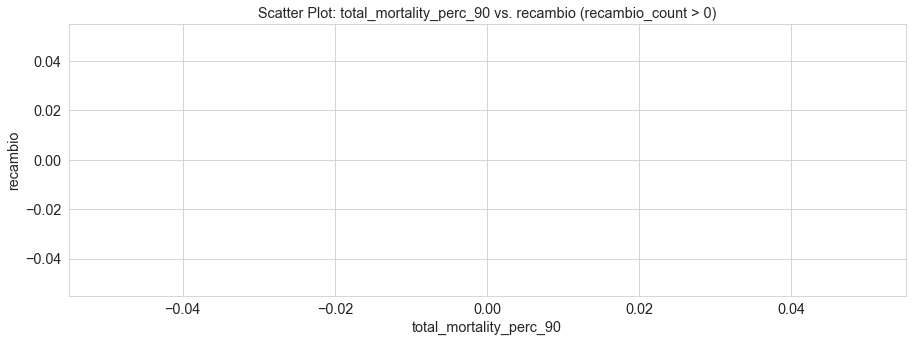

In [127]:

filtered_df = joined_df[joined_df['recambio'] > 0]

# Create the scatter plot
plt.scatter(filtered_df['total_mortality_perc_90'], filtered_df['recambio'])

# Set the axis labels
plt.xlabel('total_mortality_perc_90')
plt.ylabel('recambio')

# Set the title
plt.title('Scatter Plot: total_mortality_perc_90 vs. recambio (recambio_count > 0)')

# Display the plot
plt.show()


C:\Users\podol\AppData\Roaming\Python\Python38\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\podol\AppData\Roaming\Python\Python38\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([0.00292633, 0.00257482, 0.00439094, 0.00622007, 0.00779318,
        0.0099174 , 0.01262024, 0.0159082 , 0.01928946, 0.01957081,
        0.01771709, 0.01447108, 0.01192374, 0.01094227, 0.01057413,
        0.00943426, 0.00862276, 0.00637919, 0.00669671, 0.00438081,
        0.00376748, 0.00427956, 0.00374434, 0.00351651, 0.00317875,
        0.00341164, 0.00309123, 0.00222042, 0.00321563, 0.06722093]),
 array([  0.        ,   3.33333333,   6.66666667,  10.        ,
         13.33333333,  16.66666667,  20.        ,  23.33333333,
         26.66666667,  30.        ,  33.33333333,  36.66666667,
         40.        ,  43.33333333,  46.66666667,  50.        ,
         53.33333333,  56.66666667,  60.        ,  63.33333333,
         66.66666667,  70.        ,  73.33333333,  76.66666667,
         80.        ,  83.33333333,  86.66666667,  90.        ,
         93.33333333,  96.66666667, 100.        ]),
 <a list of 30 Patch objects>)

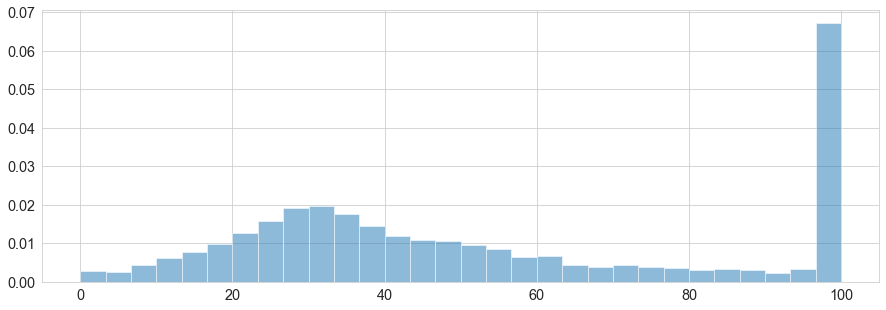

In [128]:
data=dft_filled_recambio['recambio']
plt.hist(data, bins=30, alpha=0.5, label='Data 0', density=True)

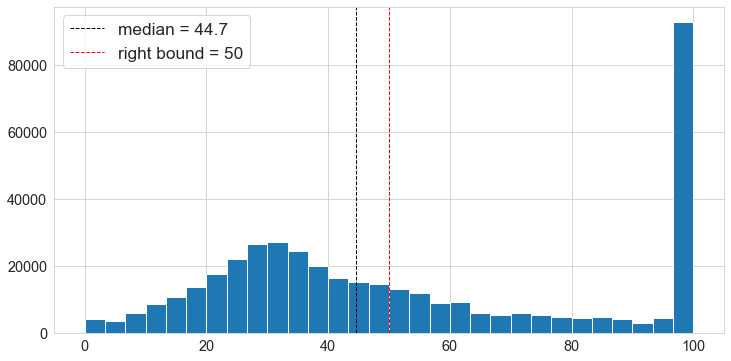

In [129]:
sns.set_style("whitegrid")
#histogram for slide:
# Filter the data within the desired range
filtered_data = dft_filled_recambio
# filtered_data = ph_data_with_dates[ph_data_with_dates.shipout_year==2023][ph_data_with_dates.ph_value.between(6.5, 8)]


# Set the figure size
plt.figure(figsize=(12, 6))  # Adjust the values (width, height) as desired

# Create the histogram plot
plt.hist(filtered_data.recambio, bins=30)

# Set the x-ticks with a step of 0.1
#plt.xticks(np.arange(6.6, 7.9, 0.1))
# Add a vertical dashed line for the median value
median_value = filtered_data.recambio.median()

# Add additional dashed lines for the left and right bounds
#left_bound = 6.8
right_bound = 50
#plt.axvline(left_bound, color='red', linestyle='dashed', label=f'left bound = {left_bound}', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', label=f'median = {median_value:.1f}', linewidth=1)
plt.axvline(right_bound, color='red', linestyle='dashed', label=f'right bound = {right_bound}', linewidth=1)
# Calculate the fraction of values above the right_bound
#fraction_above_right_bound = (filtered_data.ph_value > right_bound).mean()

# Add the fraction as a text annotation
#plt.text(7.23, 150000, f'Fracton of pH values above {right_bound}: {fraction_above_right_bound*100:.0f}%', fontsize=17)

# Add a legend
plt.legend()
# Display the plot
# plt.show()

# plt.savefig('Visualisation/Histograms/ph_values2.png')

In [130]:

filtered_df = dft_filled_recambio
#[dft_filled_nh4['final_locus_population_id'].isin(full_cycles)]

# Group the filtered dataframe by final_locus_population_id
grouped_df = filtered_df.groupby('final_locus_population_id')

# Calculate the count of event_date values where NH4 is higher than the percentile for each group
count_values = grouped_df.apply(lambda x: (x['recambio'] > 0.5).sum())

# Print the resulting count_values for each final_locus_population_id
print(count_values)


final_locus_population_id
36783130       0
36783339       0
36783413       0
36783453       0
36783456       0
            ... 
194650512    263
194650513    263
194650515    263
194650516    263
194650523    263
Length: 3176, dtype: int64


In [131]:
count_values.name = 'recambio_more05'  # Assign a name to the Series
joined_df = joined_df.merge(count_values, how='left', left_on='from_locus_population_id', right_index=True)

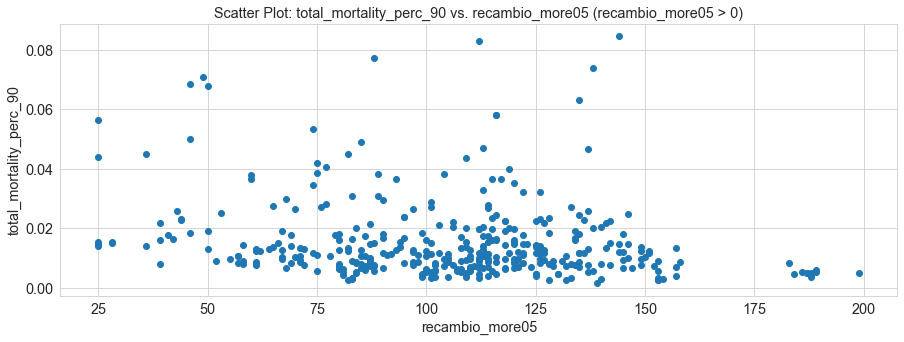

In [132]:

filtered_df = joined_df[joined_df['recambio_more05'] > 0]

# Create the scatter plot
plt.scatter( filtered_df['recambio_more05'],filtered_df['total_mortality_perc_90'])

# Set the axis labels
plt.ylabel('total_mortality_perc_90')
plt.xlabel('recambio_more05')

# Set the title

plt.title('Scatter Plot: total_mortality_perc_90 vs. recambio_more05 (recambio_more05 > 0)')

# Display the plot
plt.show()

In [133]:
sns.set_style("whitegrid")

step=20

factor = 'relative_higher_max'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'mortality'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/1.5 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

NameError: name 'factors_df' is not defined

In [134]:
filtered_df.count()

locus_id               382
fish_group_id          382
transfer_year          382
transfer_month         382
transfer_month_year    382
                      ... 
mortality 14d          382
delta                  382
delta min              382
recambio               382
recambio_more05        382
Length: 74, dtype: int64

In [135]:
filtered_df = dft_filled_recambio

grouped_df = filtered_df.groupby('final_locus_population_id')

average_values = grouped_df['recambio'].mean()

print(average_values)


final_locus_population_id
36783130           NaN
36783339           NaN
36783413           NaN
36783453           NaN
36783456           NaN
               ...    
194650512    79.595466
194650513    79.595466
194650515    79.595466
194650516    79.595466
194650523    79.595466
Name: recambio, Length: 3176, dtype: float64


In [136]:
#joined_df = joined_df.drop(columns=['recambio_average'])

In [137]:
average_values.name = 'recambio_average'  # Assign a name to the Series
joined_df = joined_df.merge(average_values, how='left', left_on='from_locus_population_id', right_index=True)

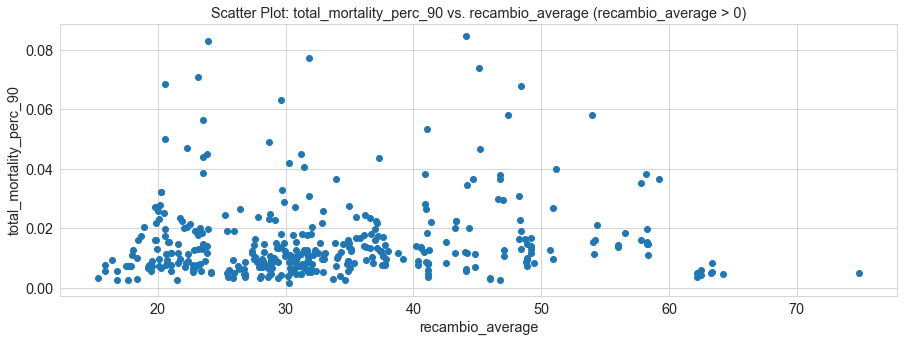

In [138]:

filtered_df = joined_df[joined_df['recambio_average'] > 0]

# Create the scatter plot
plt.scatter(filtered_df['recambio_average'],filtered_df['total_mortality_perc_90'])

# Set the axis labels
plt.ylabel('total_mortality_perc_90')
plt.xlabel('recambio_average')

# Set the title

plt.title('Scatter Plot: total_mortality_perc_90 vs. recambio_average (recambio_average > 0)')

# Display the plot
plt.show()

In [139]:
columns_of_interest = ['total_mortality_perc_90', 'recambio_average']
selected_df = filtered_df[columns_of_interest]

# Calculate the correlation
correlation = selected_df.corr()

In [140]:
filtered_df.to_csv("recambio.csv")

In [141]:
correlation

,total_mortality_perc_90,recambio_average
total_mortality_perc_90,1.000000,0.074855
recambio_average,0.074855,1.000000


In [142]:
full_cycles = [
    194527129, 
    194497496,
    193247058,
    194516980,
    194546436,
    38193840,
    194352023,
    194503079,
    193343886,
    194530157,
    194497483,
    194503096,
    194522881,
    193249474,
    193247433,
    194523185,
    194512165
]

### Non-smoothed

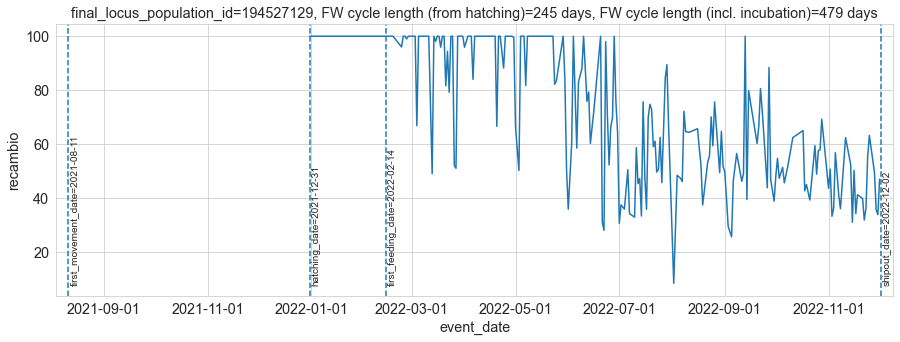

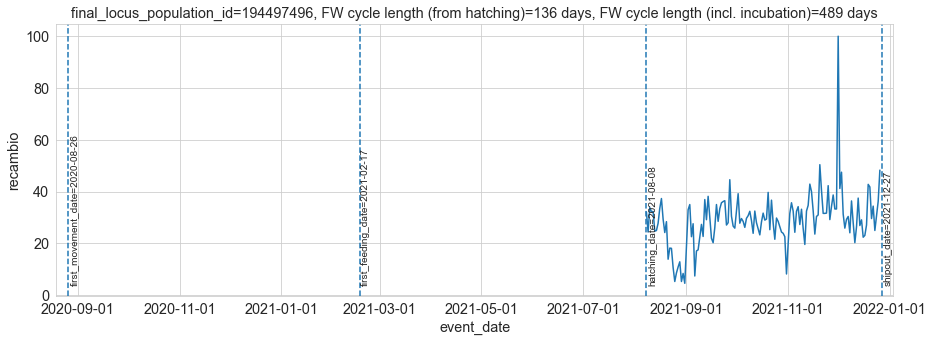

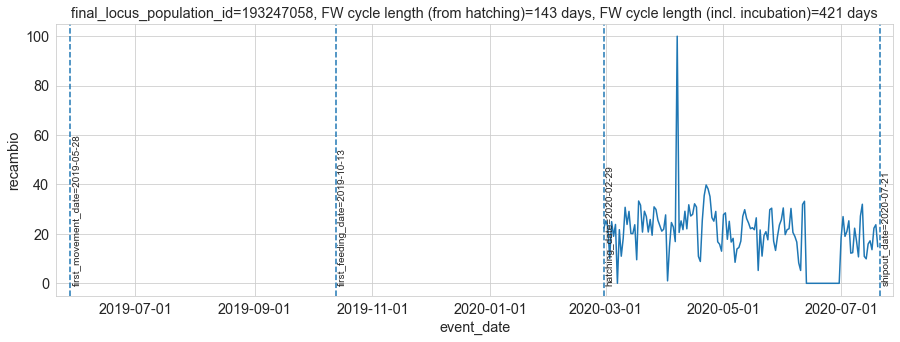

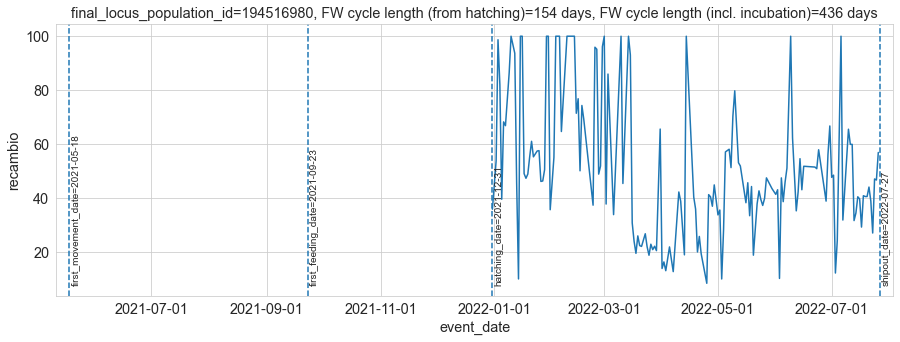

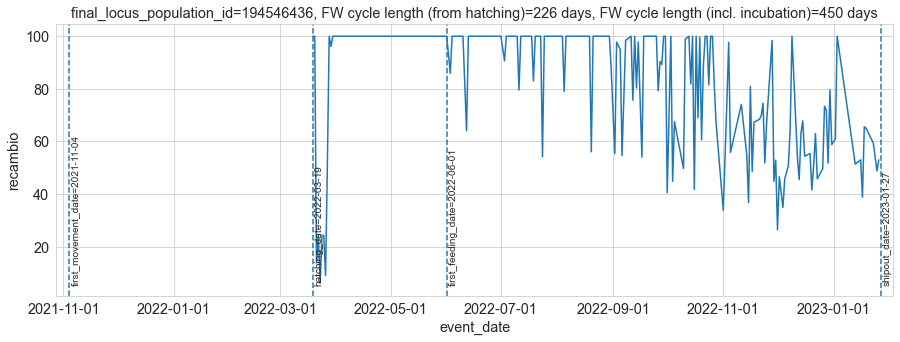

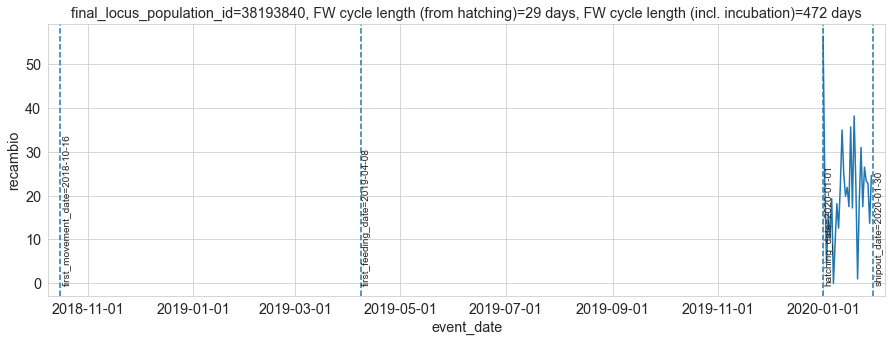

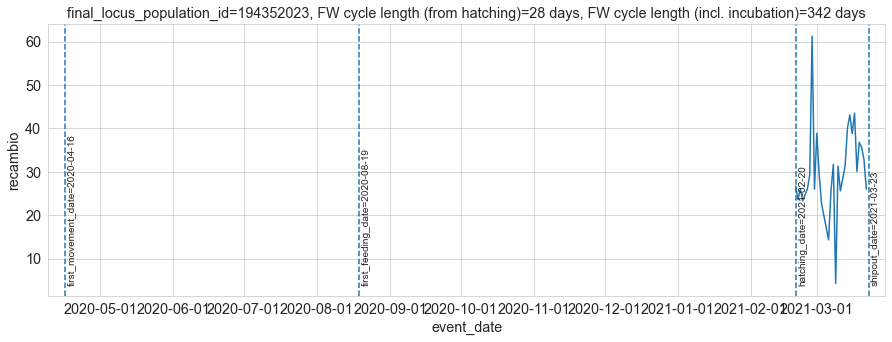

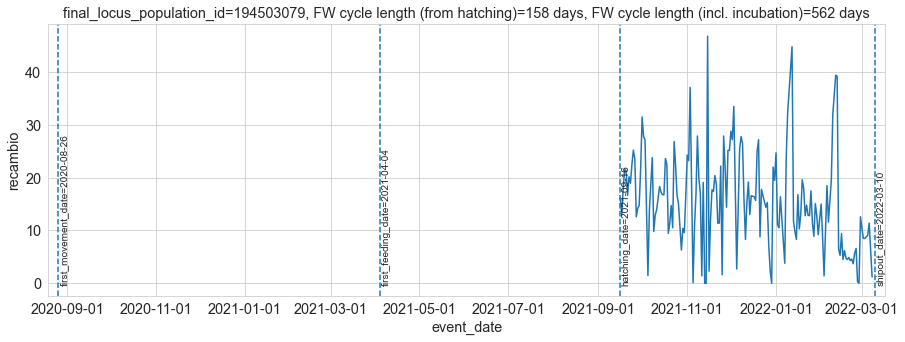

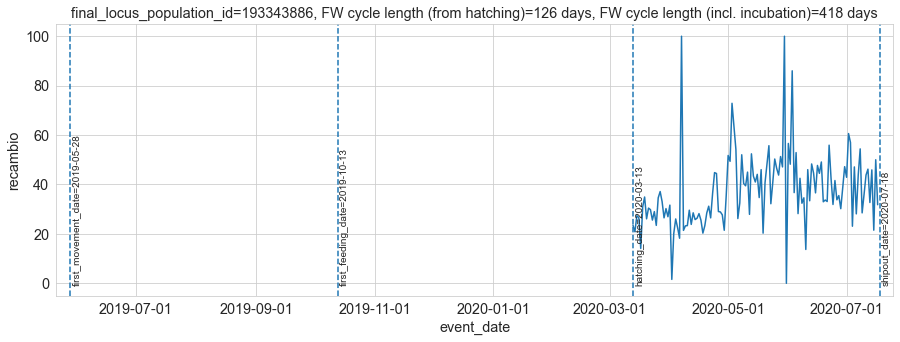

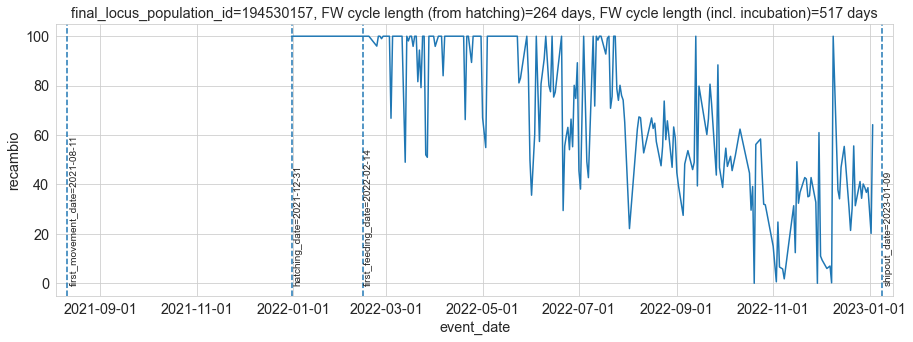

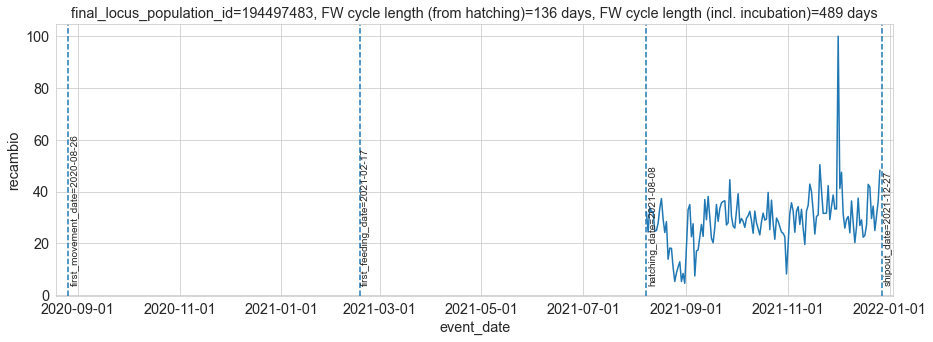

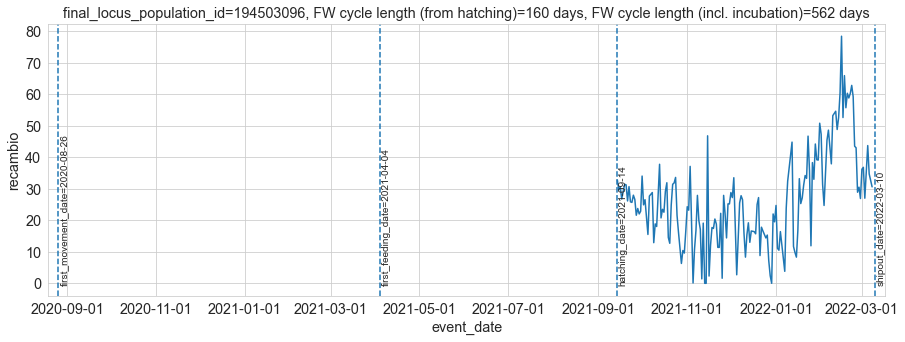

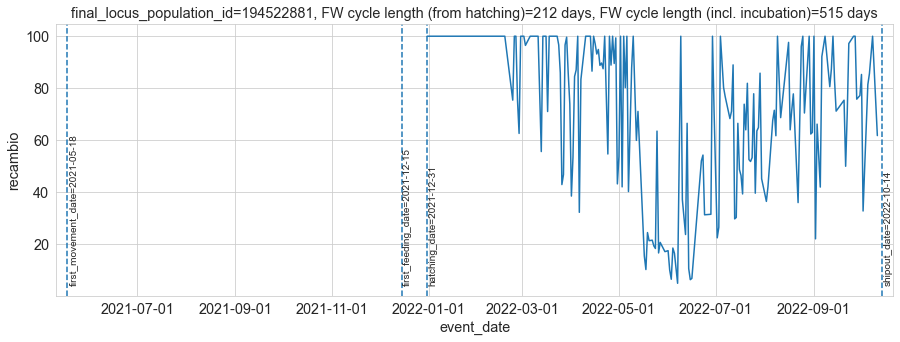

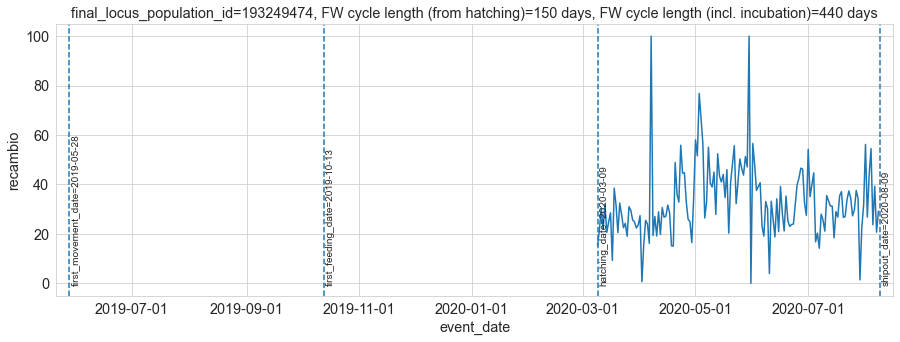

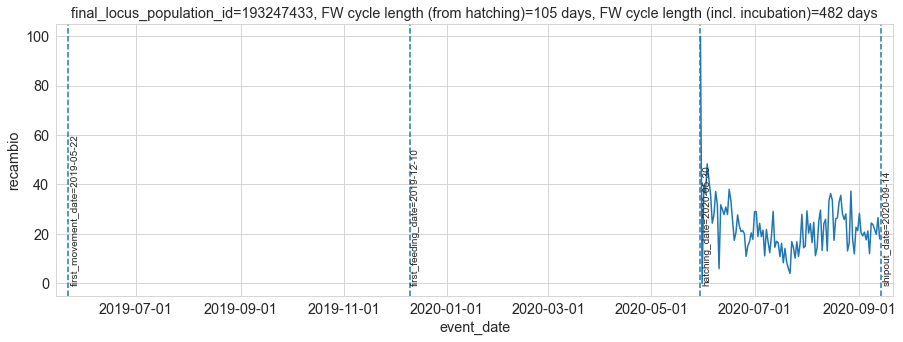

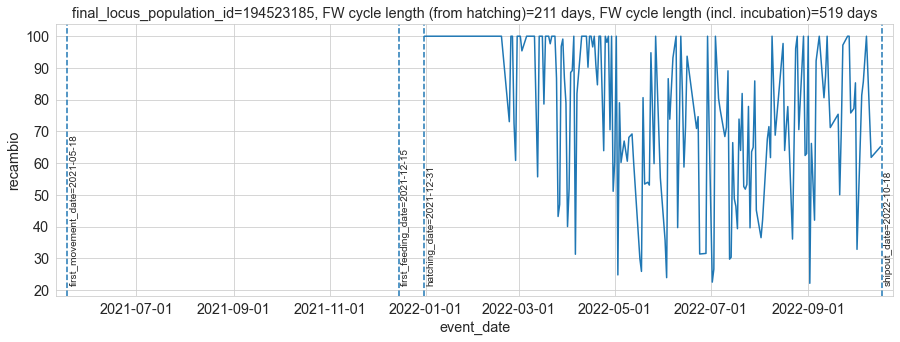

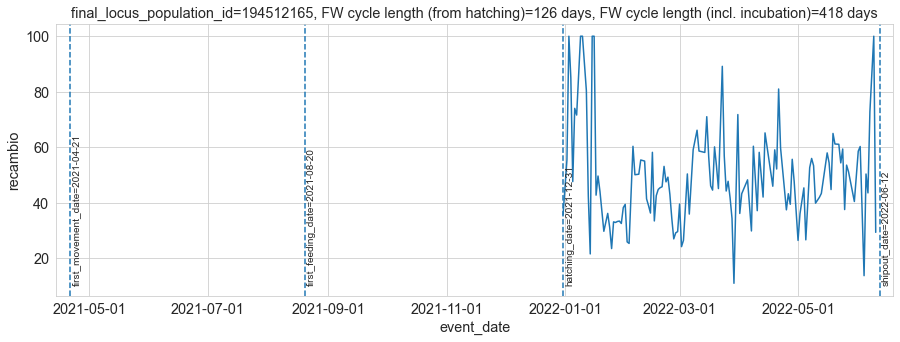

In [143]:
#plot temperature time series charts
j=0
for lp in full_cycles:
    filtered_df = dft_filled_recambio[dft_filled_recambio.final_locus_population_id==lp]
    if filtered_df.recambio.isna().sum() != filtered_df.recambio.shape[0]:
        j+=1
        if (j%100==0): print(j)
        fig, axs = plt.subplots(1, 1)
        sns.lineplot(data=filtered_df, x='event_date',y='recambio')
        chart_title = 'final_locus_population_id='+str(lp)+', FW cycle length (from hatching)='+str(len(filtered_df.dropna()))+' days' +', FW cycle length (incl. incubation)='+str(len(filtered_df))+' days' 
        plt.title(chart_title)
        min_recambio = filtered_df.recambio.min()
        first_movement_date = filtered_df.event_date.min()
        #not exact definition of hatching date - figure out with James
        hatching_date = filtered_df.dropna().event_date.min()
        shipout_date = filtered_df.event_date.max()
        first_feeding_date=df_dates[df_dates.pretransfer_fw_locus_population_id==lp].first_feeding_date.iloc[0]
        plt.xlim(first_movement_date-datetime.timedelta(days=7),shipout_date+datetime.timedelta(days=7))
        axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        if (hatching_date-first_movement_date).days<7:
            dates_dict = {
                 'hatching_date': hatching_date,
                 'first_feeding_date': first_feeding_date,
                 'shipout_date': shipout_date}
        else:
            dates_dict = {'first_movement_date': first_movement_date,
                 'hatching_date': hatching_date,
                 'first_feeding_date': first_feeding_date,
                 'shipout_date': shipout_date}
        for i, (name, date) in enumerate(dates_dict.items()):
            plt.axvline(date, linestyle='--')
            plt.text(date + datetime.timedelta(days=1), min_recambio, name+'='+date.strftime("%Y-%m-%d"), rotation=90)
        
        plt.show()
        #plt.savefig('Visualisation\\'+chart_title+'.jpg')
        fig.savefig(f'recambio_vs_time_{chart_title}.png')
        plt.close()
        #plt.close()

In [ ]:
Поделить ингресадос на объем клетки. Если разница, то рекамбио
1) кол-во дней больше 50 процентов
2) что происходит в дни, когда рекамбио больше 50% (опционально)
3) nh4 за последние n дней перед трансфером
4) кол-во дней с высоким nh4

### Smoothing

In [29]:
def get_mean_last_week(df, x):
    df = df.copy().reset_index()
    idx = df[df.Ingresados == x].index[0]
    if idx > 7:
        return df.Ingresados.iloc[idx-7:idx].mean(skipna=True)
    else:
        return df.Ingresados.iloc[:idx].mean(skipna=True)

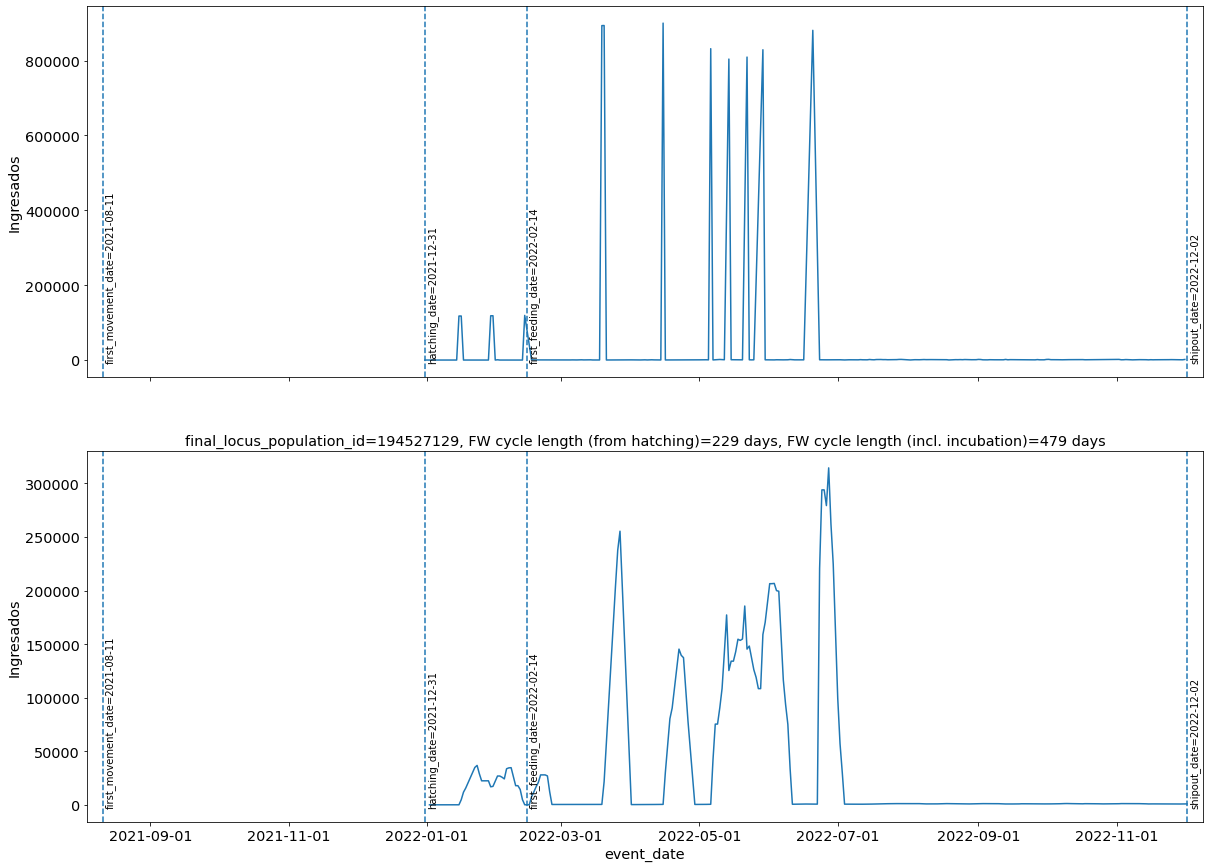

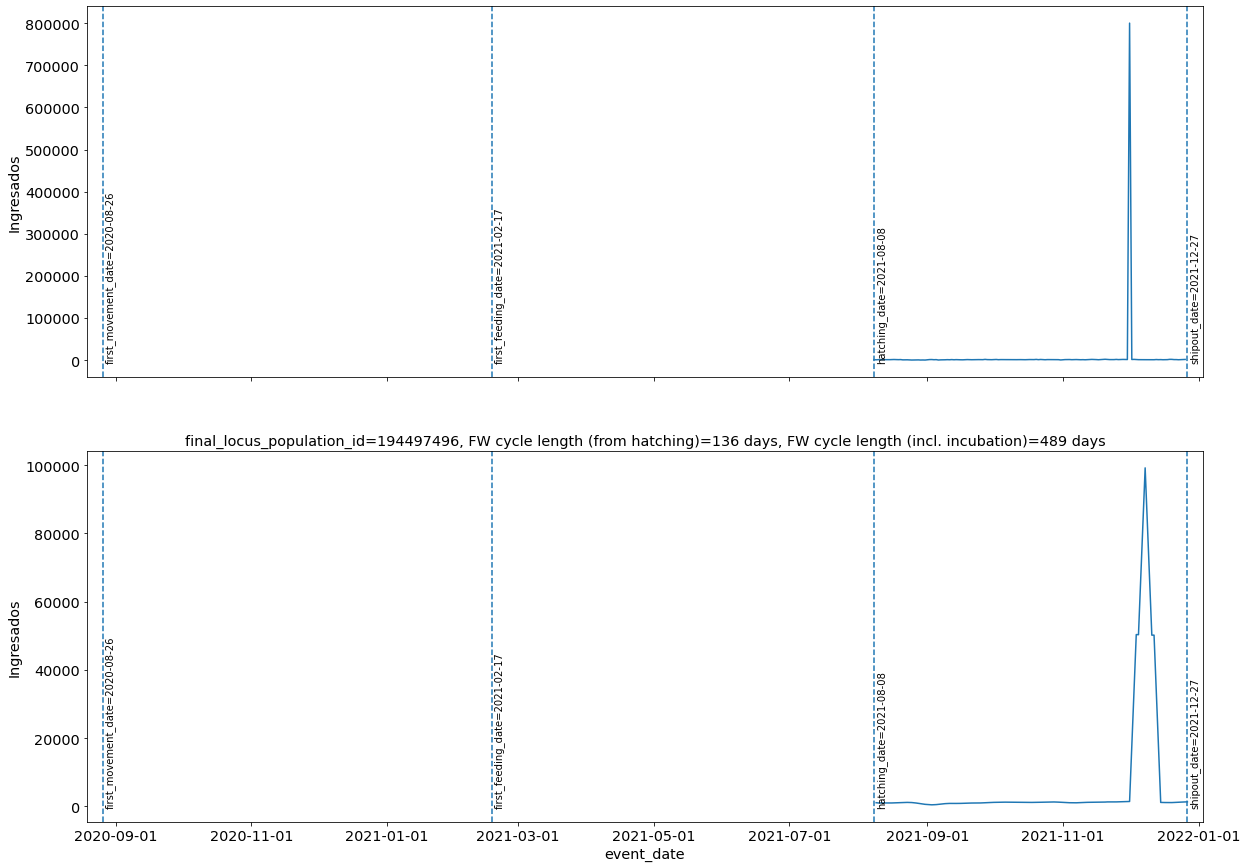

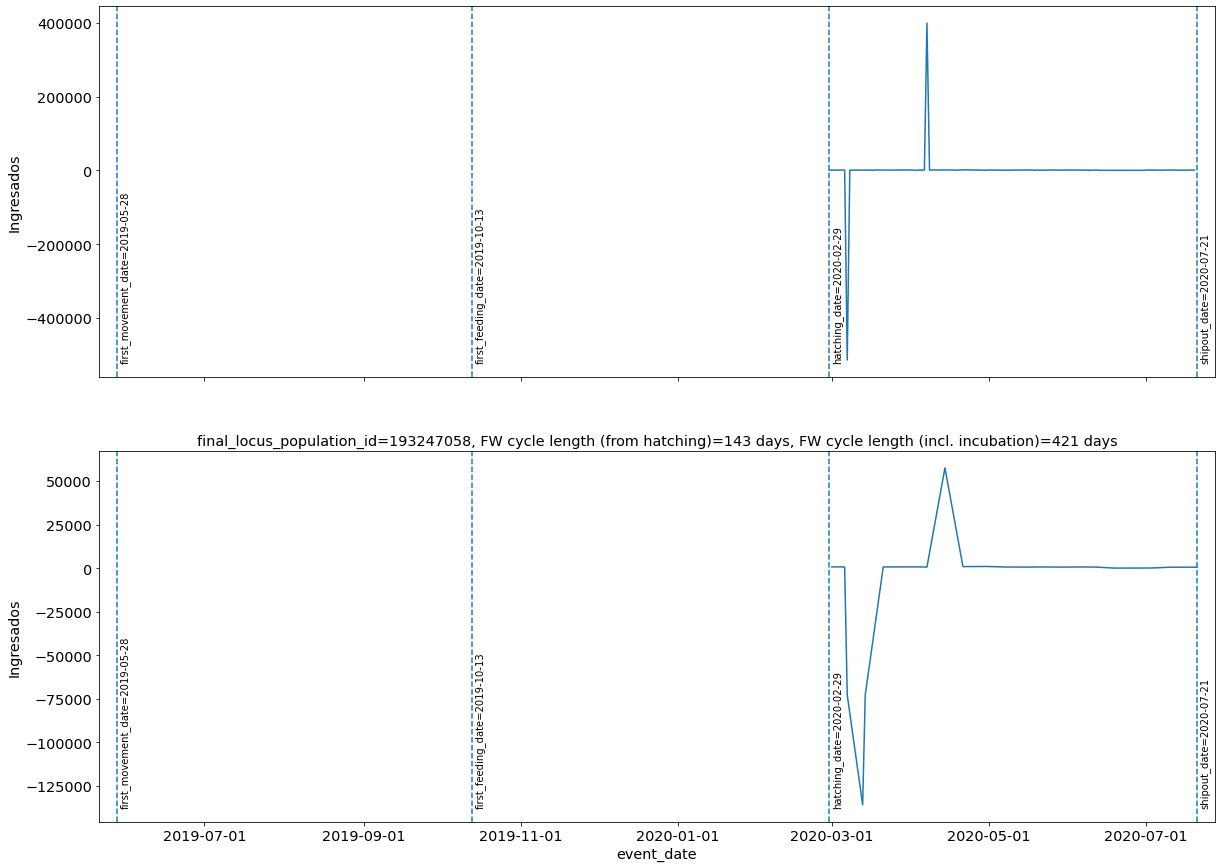

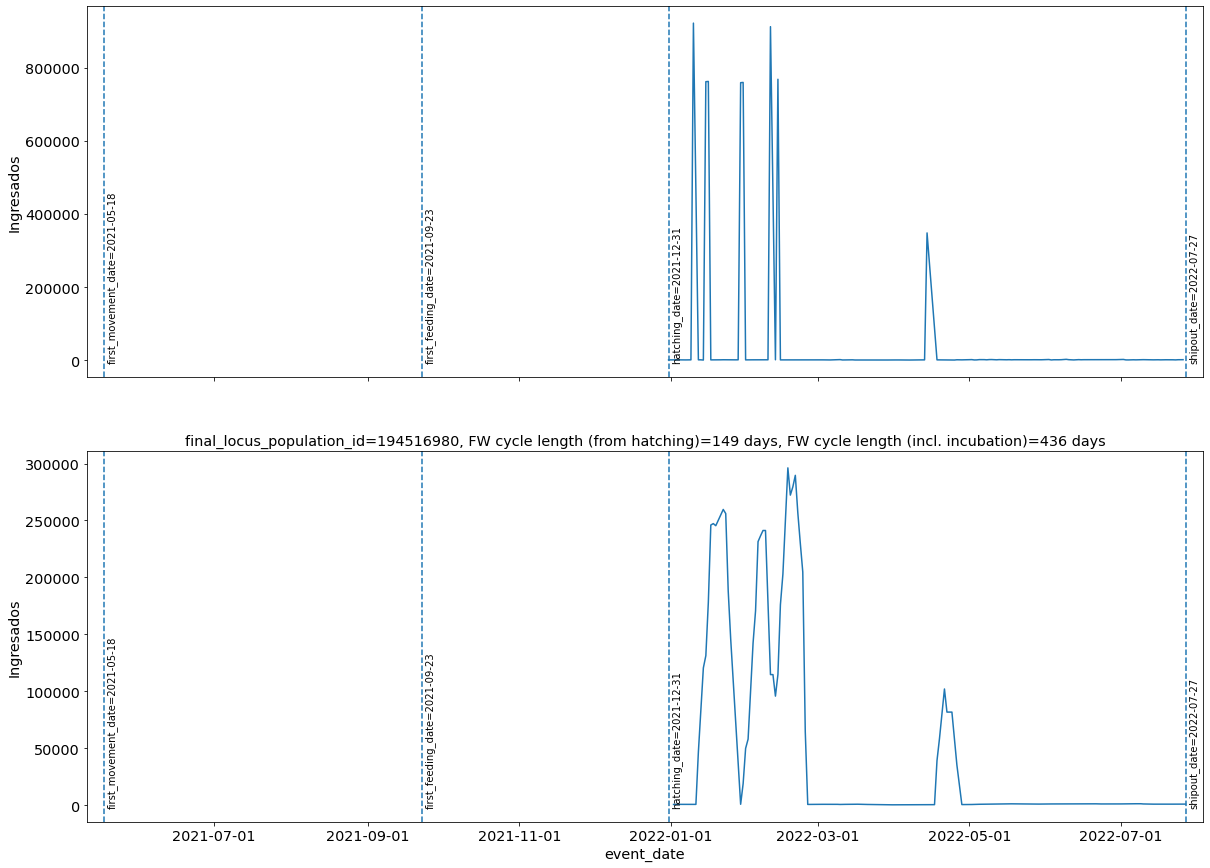

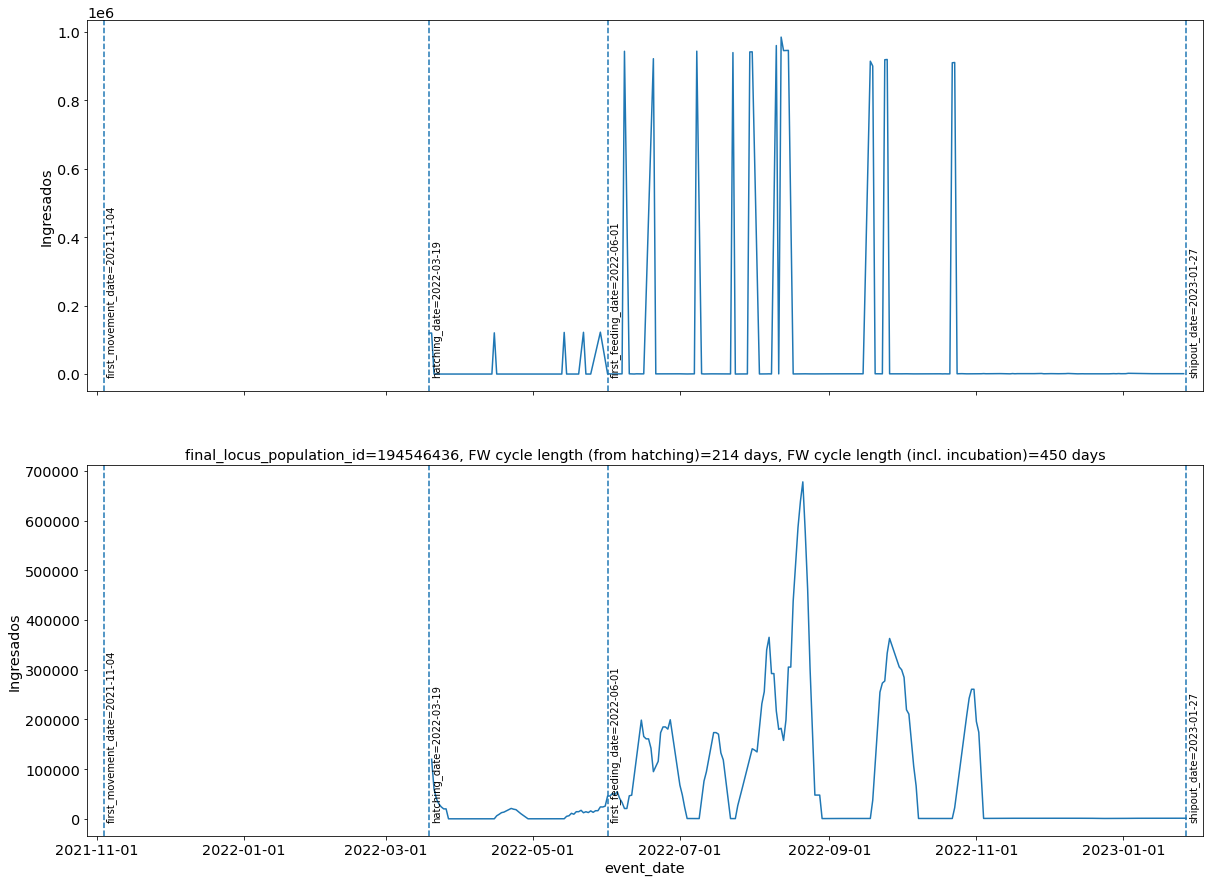

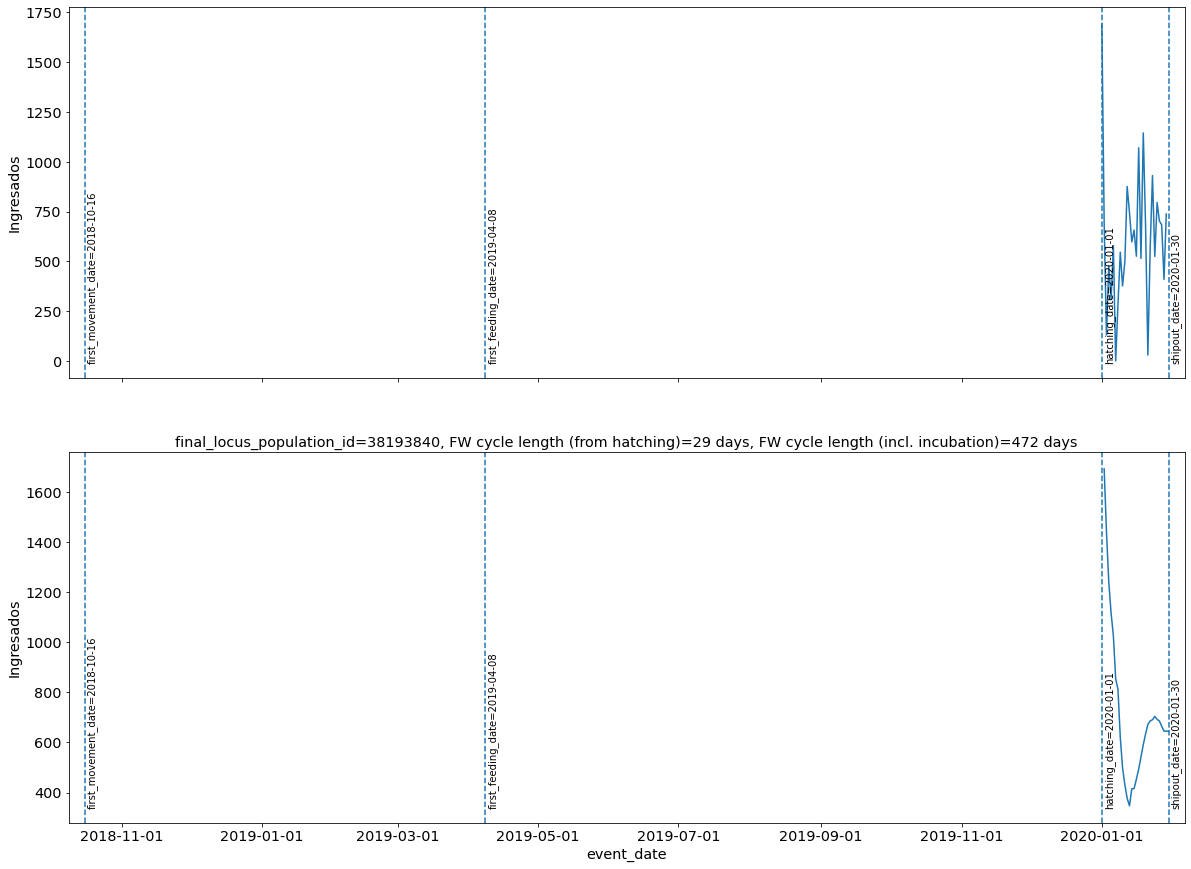

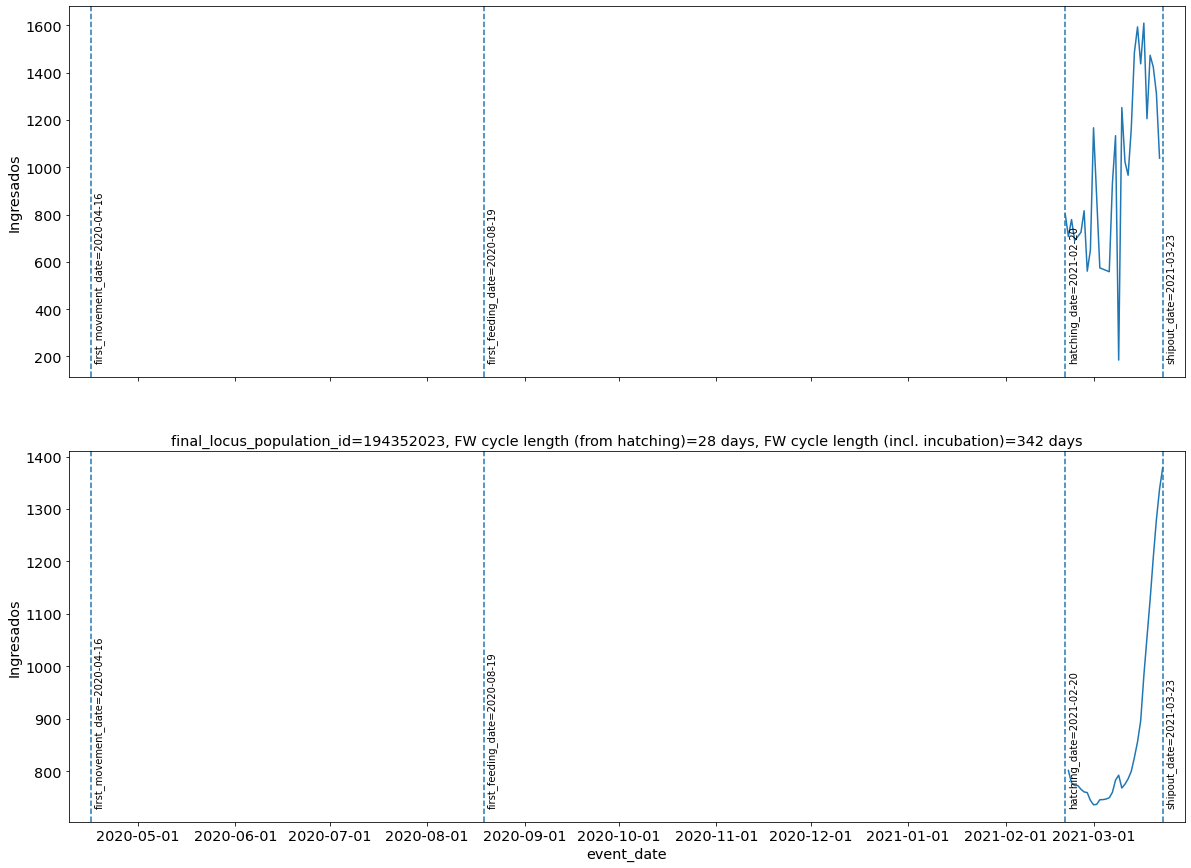

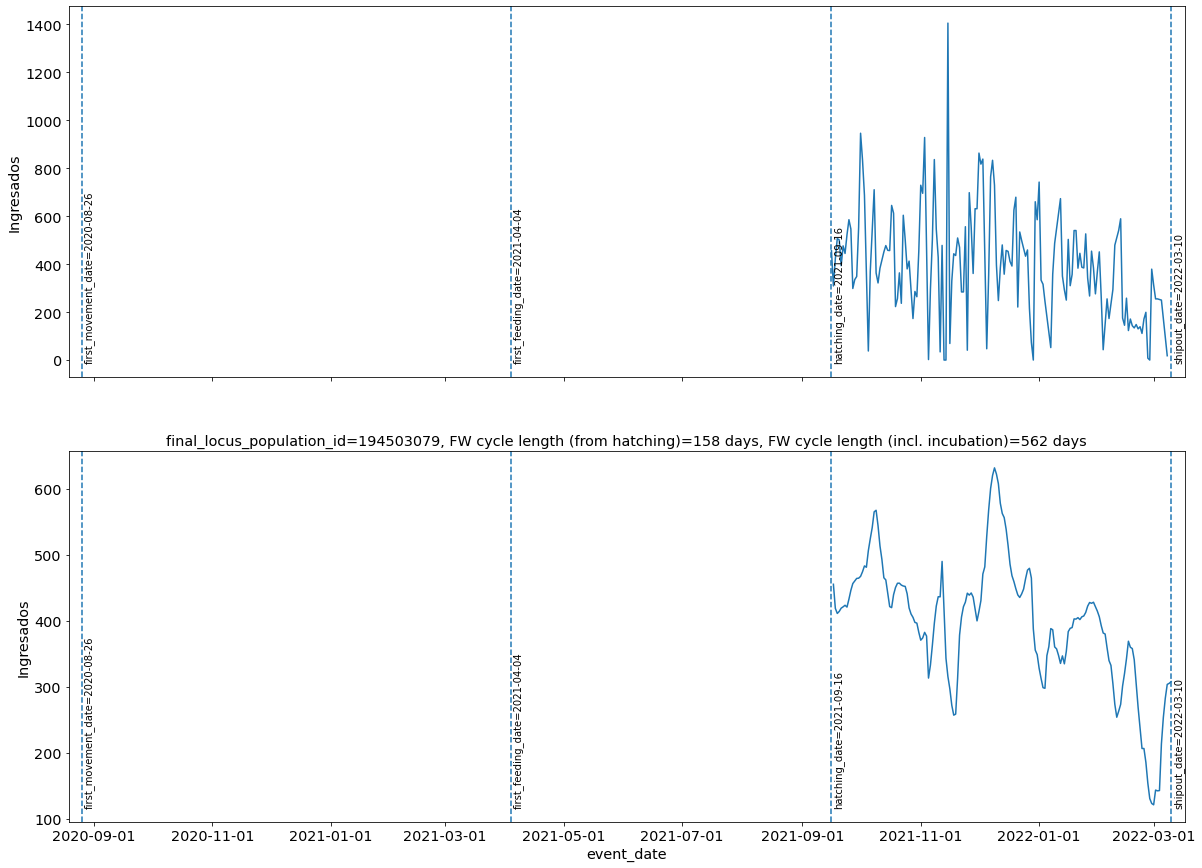

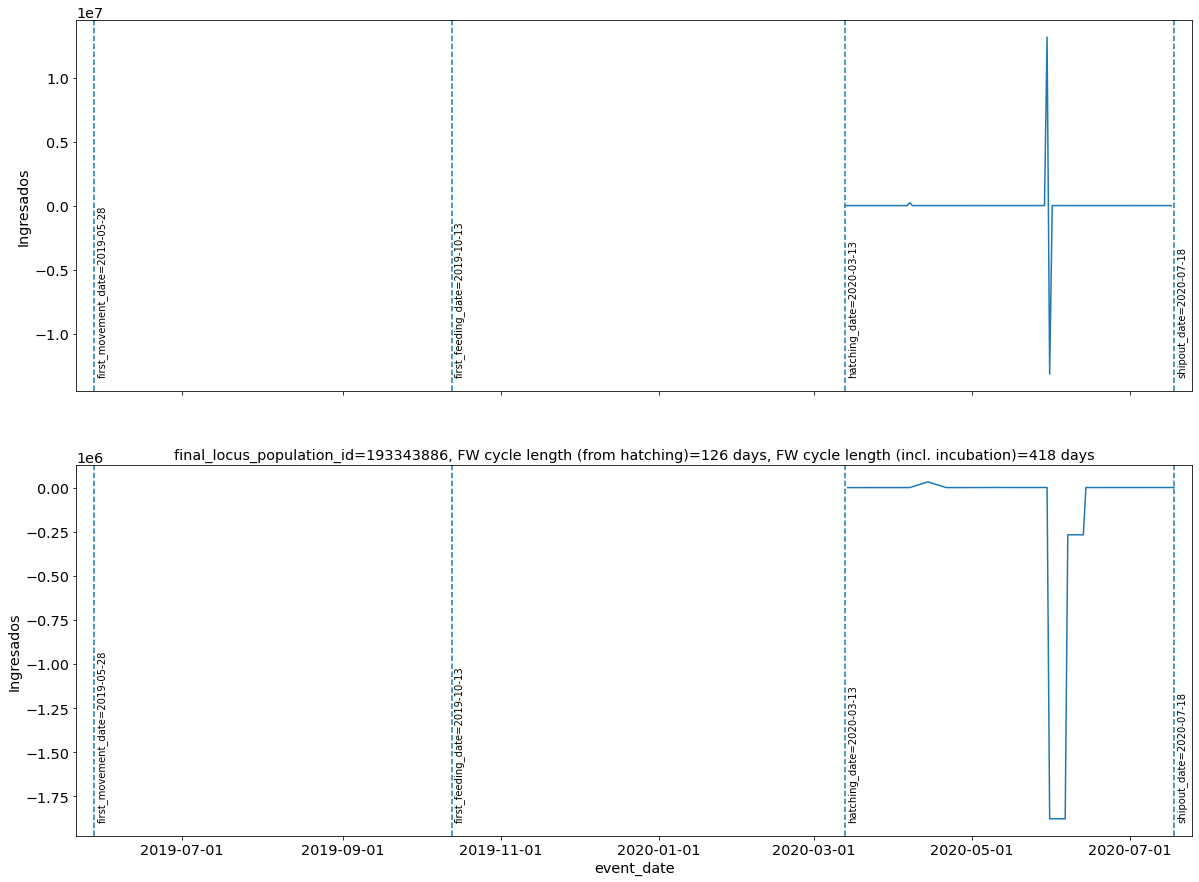

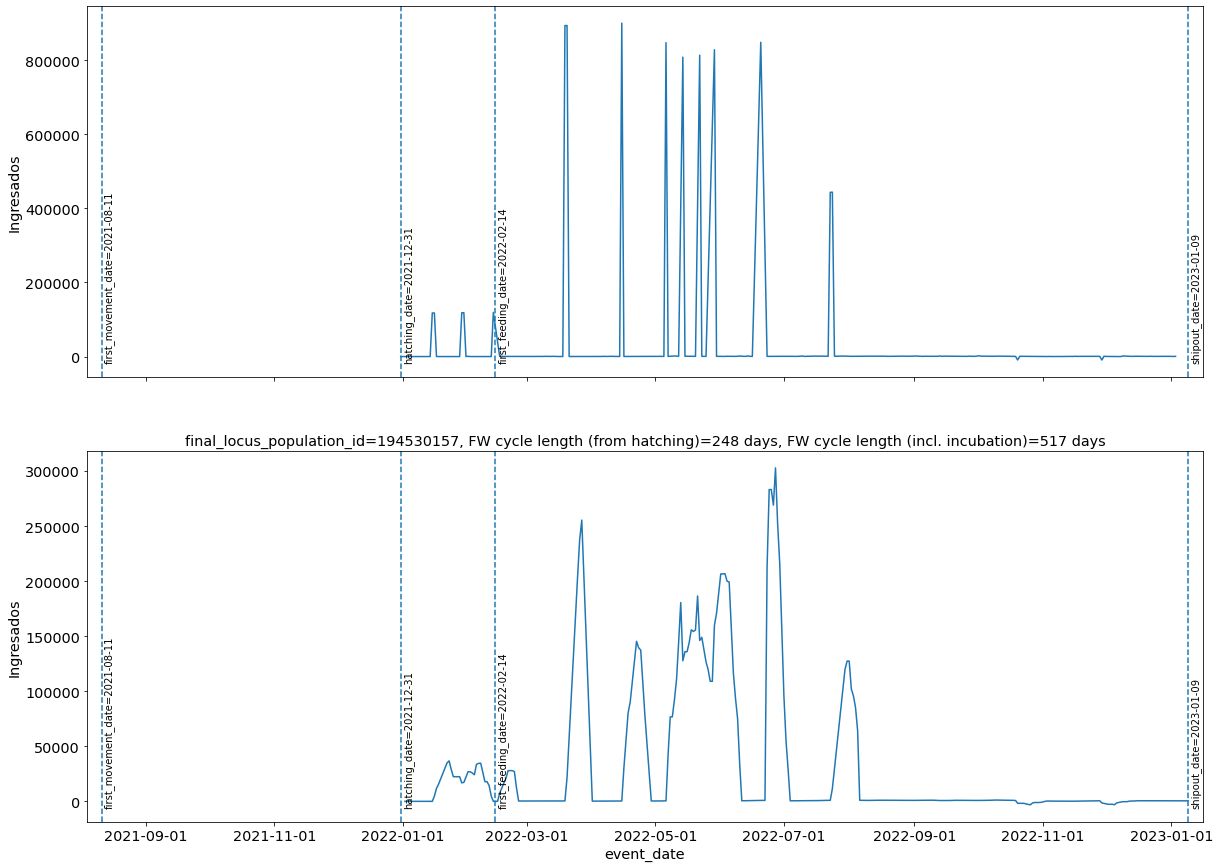

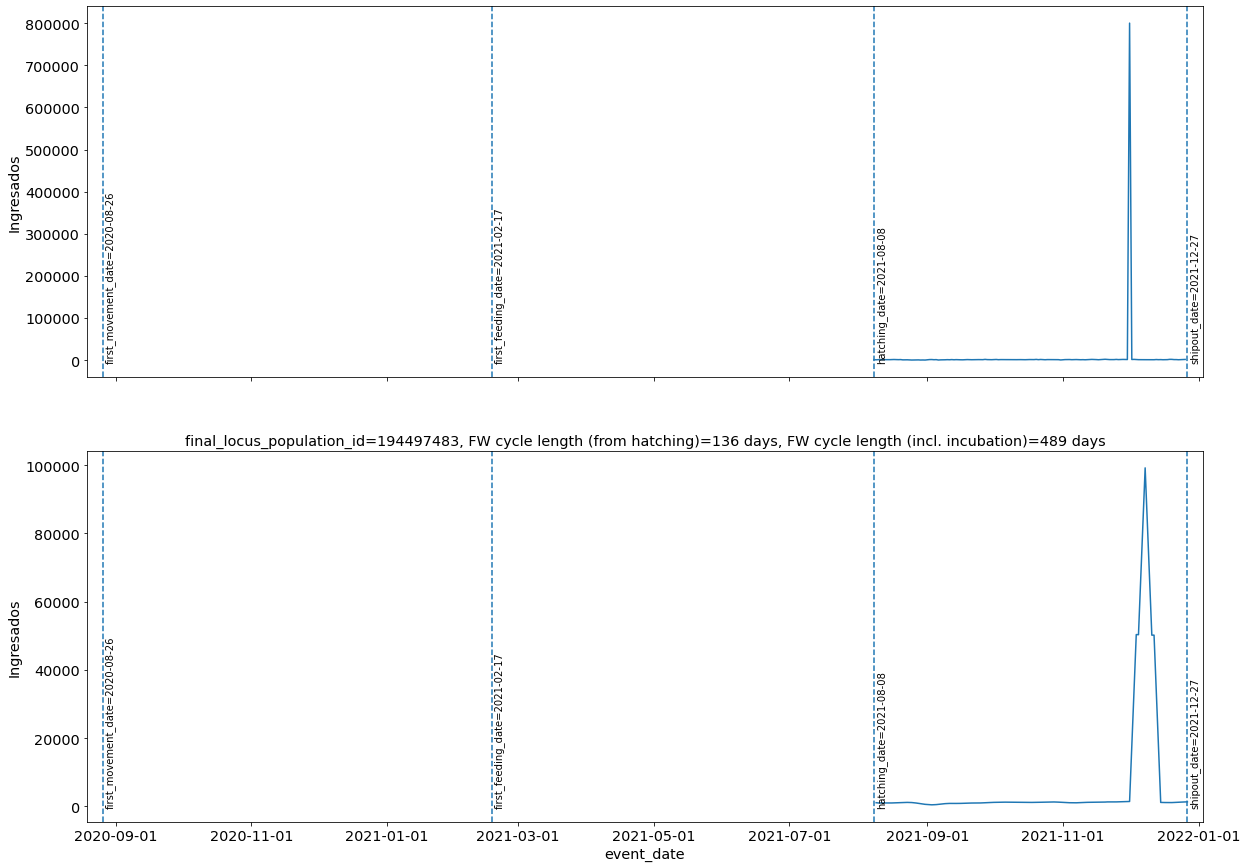

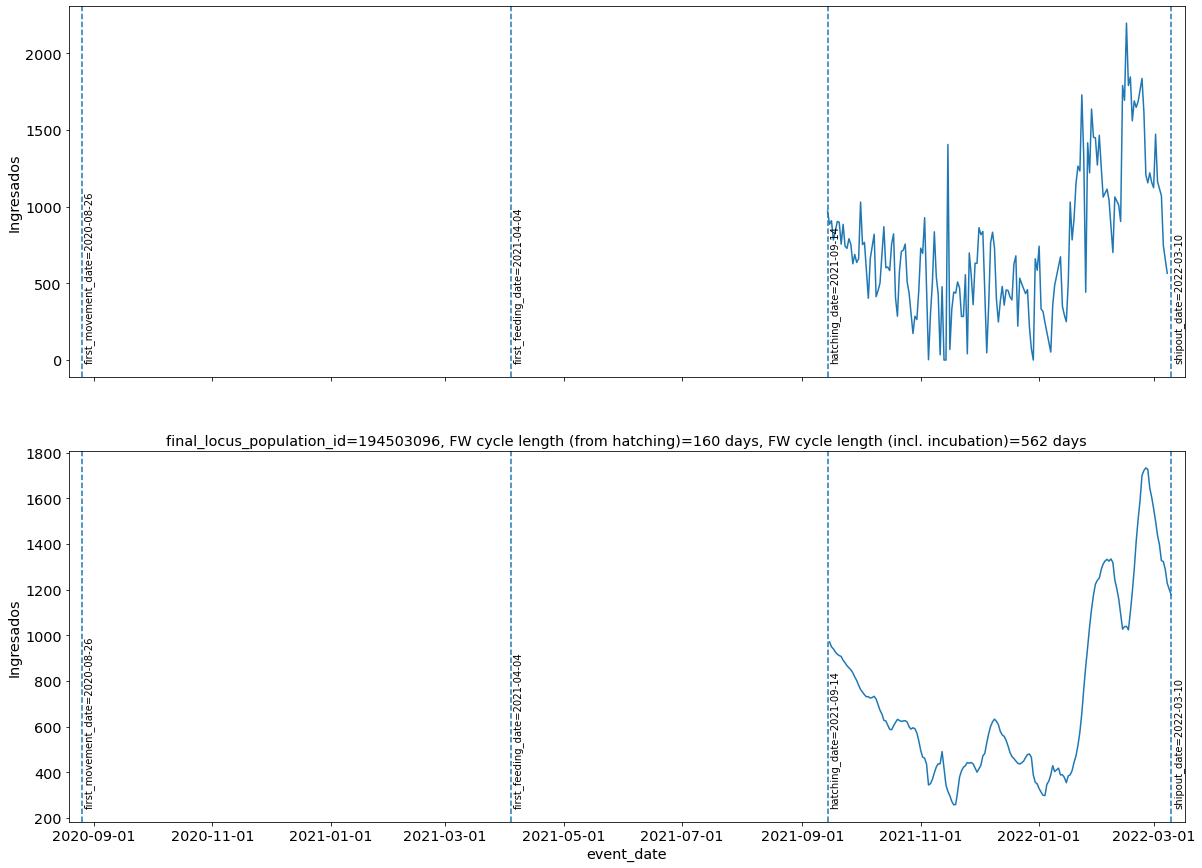

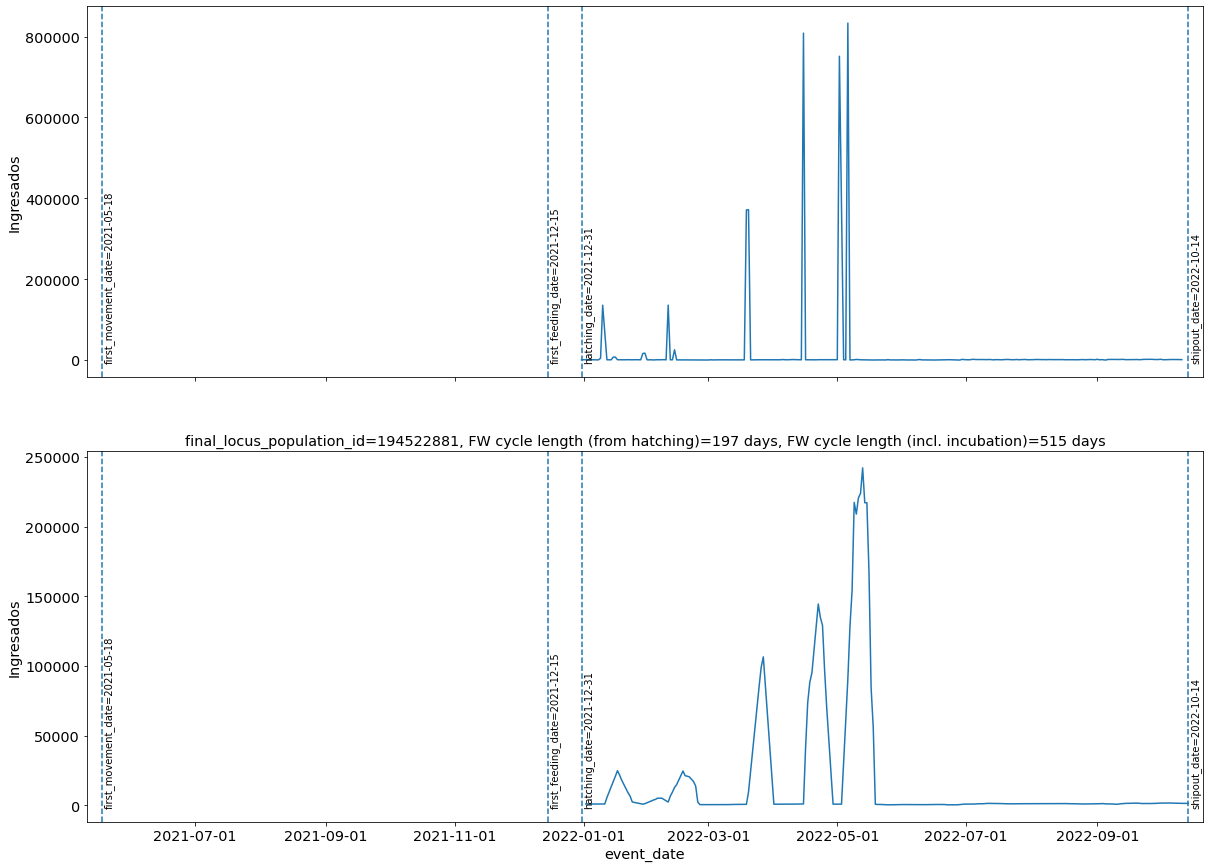

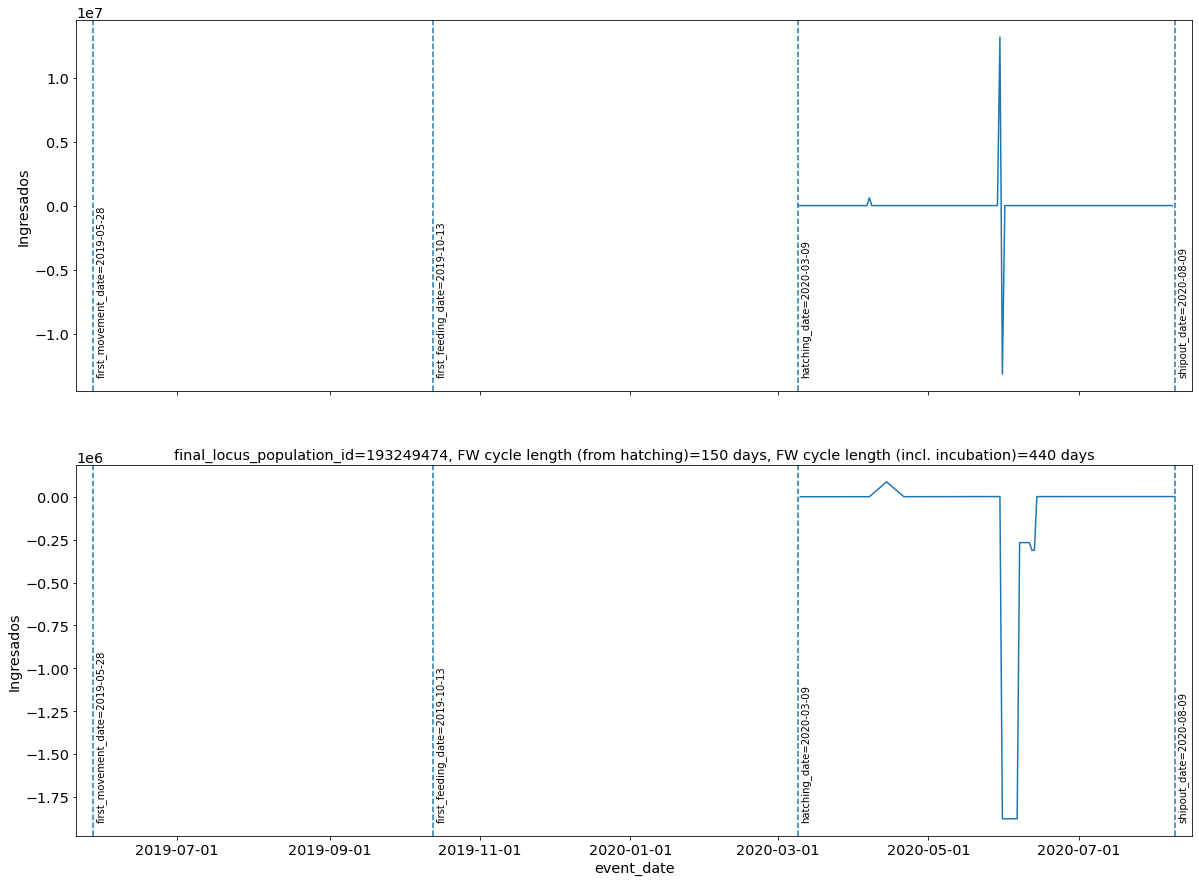

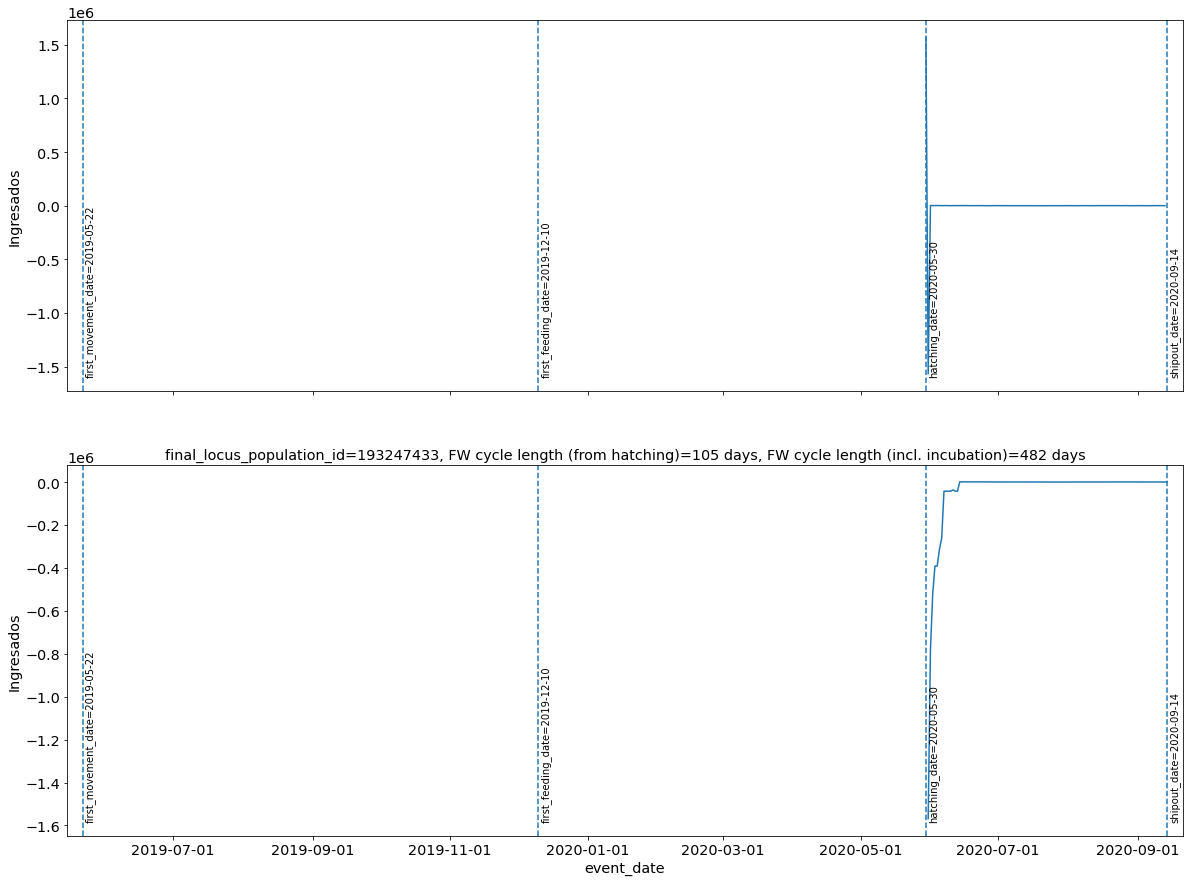

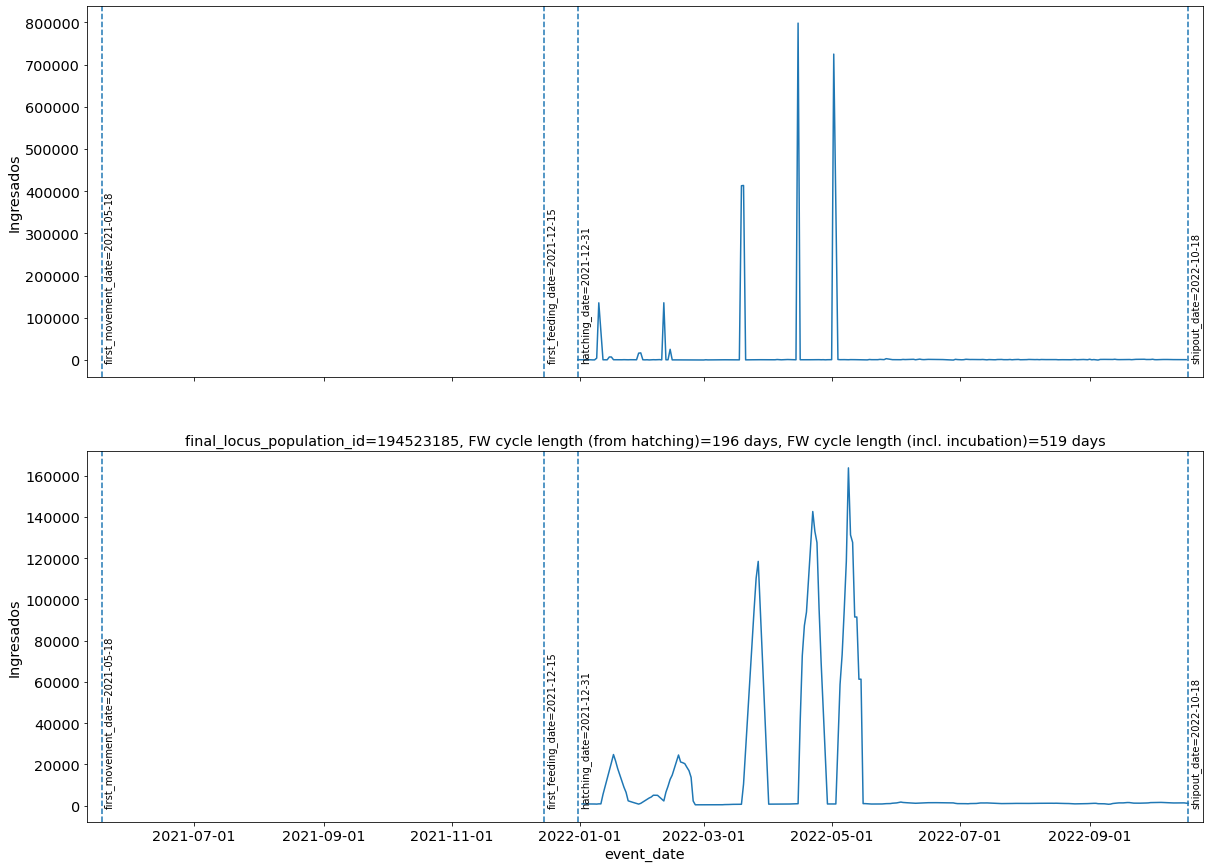

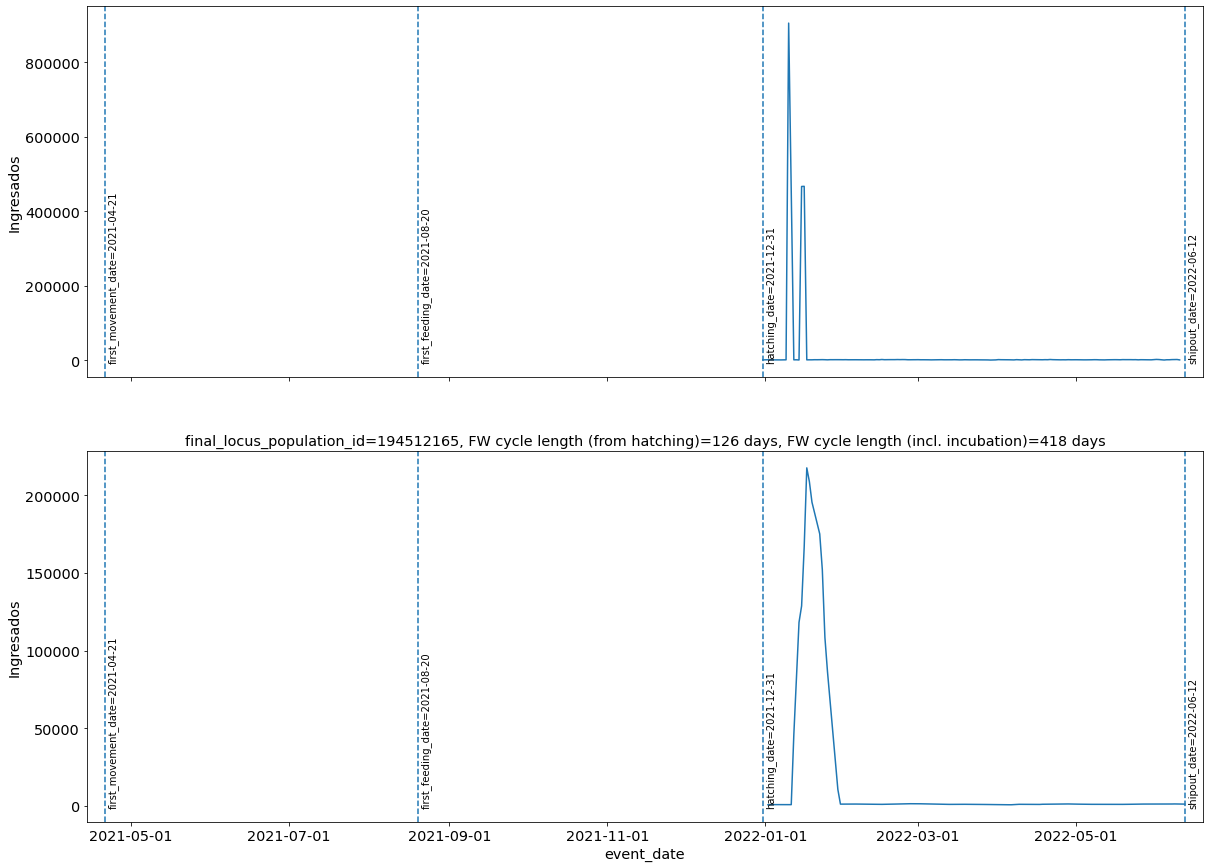

In [30]:
#plot temperature time series charts
j=0
for lp in full_cycles:
# or for all final_locus_population_id 
#for lp in dft_filled_ph.final_locus_population_id.unique():
    filtered_df = dft_filled_ingresados[dft_filled_ingresados.final_locus_population_id==lp]
    smoothed_filtered_df = filtered_df.copy()
    
    # replace values > 14 (like 72 instead of 7.2) with the mean of last weak
    smoothed_filtered_df.Ingresados = smoothed_filtered_df.Ingresados.\
    apply(lambda x: x if (pd.isna(x) or x) < 14 else get_mean_last_week(smoothed_filtered_df, x))
    # weekly rolling window moving averge
    smoothed_filtered_df.Ingresados = smoothed_filtered_df.Ingresados.rolling(7, min_periods=1).mean()
    if filtered_df.Ingresados.isna().sum() != filtered_df.Ingresados.shape[0]:  # check if ph data is not np.nan-only
        j+=1
        if (j%100==0): 
            print(j)
        
        fig, axs = plt.subplots(2, 1, figsize=(20, 15), sharex='col')

        sns.lineplot(data=filtered_df, x='event_date',y='Ingresados', ax=axs[0])
        sns.lineplot(data=smoothed_filtered_df, x='event_date',y='Ingresados', ax=axs[1])

        chart_title = 'final_locus_population_id='+str(lp)+', FW cycle length (from hatching)='+str(len(filtered_df.dropna()))+' days' +', FW cycle length (incl. incubation)='+str(len(filtered_df))+' days' 
        plt.title(chart_title)
        min_ingresados, smoothed_min_ingresados, = filtered_df.Ingresados.min(), smoothed_filtered_df.Ingresados.min()
        first_movement_date = filtered_df.event_date.min()
        #not exact definition of hatching date - figure out with James
        hatching_date = filtered_df.dropna().event_date.min()
        shipout_date = filtered_df.event_date.max()
        first_feeding_date=df_dates[df_dates.pretransfer_fw_locus_population_id==lp].first_feeding_date.iloc[0]
        for ax in axs:
            ax.axis(xmin=first_movement_date-datetime.timedelta(days=7), xmax=shipout_date+datetime.timedelta(days=7))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        if (hatching_date-first_movement_date).days<7:
            dates_dict = {
                 'hatching_date': hatching_date,
                 'first_feeding_date': first_feeding_date,
                 'shipout_date': shipout_date}
        else:
            dates_dict = {'first_movement_date': first_movement_date,
                 'hatching_date': hatching_date,
                 'first_feeding_date': first_feeding_date,
                 'shipout_date': shipout_date}
        for i, (name, date) in enumerate(dates_dict.items()):
            for ax, y_val in zip(axs, (min_ingresados, smoothed_min_ingresados)):
                ax.axvline(date,  linestyle='--')
                ax.text(date + datetime.timedelta(days=1), y_val, name+'='+date.strftime("%Y-%m-%d"), rotation=90)
        plt.show()
        fig.savefig(f'ingresados_vs_time_{chart_title}.png')
        plt.close()